In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/exam-1/data.csv


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import optuna

In [6]:
import pandas as pd

data = pd.read_csv('/kaggle/input/exam-1/data.csv')

data.head()

,Unnamed: 0,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,...,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,doctorid,country_code
0,0,1,8,c,3,Z,3,radiotherapy,R,F,...,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,NaN,1
1,1,2,2,c,5,Z,2,radiotherapy,S,F,...,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,NaN,1
2,2,3,10,e,1,X,2,anesthesia,S,E,...,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,NaN,1
3,3,4,26,b,2,Y,2,radiotherapy,R,D,...,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,NaN,1
4,4,5,26,b,2,Y,2,radiotherapy,S,D,...,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,NaN,1


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         318438 non-null  int64  
 1   case_id                            318438 non-null  int64  
 2   Hospital_code                      318438 non-null  int64  
 3   Hospital_type_code                 318438 non-null  object 
 4   City_Code_Hospital                 318438 non-null  int64  
 5   Hospital_region_code               318438 non-null  object 
 6   Available Extra Rooms in Hospital  318438 non-null  int64  
 7   Department                         318438 non-null  object 
 8   Ward_Type                          318438 non-null  object 
 9   Ward_Facility_Code                 318438 non-null  object 
 10  Bed Grade                          318325 non-null  float64
 11  patientid                          3184

In [8]:
data.drop(columns=['Unnamed: 0', 'case_id', 'patientid', 'doctorid'], inplace=True)

In [9]:
categorical_columns = ['Hospital_code', 'City_Code_Hospital', 'City_Code_Patient', 'country_code']
data[categorical_columns] = data[categorical_columns].astype('category')

In [10]:
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Категоріальні ознаки: {categorical_features}")
print(f"Числові ознаки: {numerical_features}")

Категоріальні ознаки: ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age', 'Stay']
Числові ознаки: ['Available Extra Rooms in Hospital', 'Bed Grade', 'Visitors with Patient', 'Admission_Deposit']


In [11]:
missing_values = data.isnull().sum()

print(missing_values[missing_values > 0])

Bed Grade             113
City_Code_Patient    4532
dtype: int64


In [12]:
data['Bed Grade'] = data['Bed Grade'].fillna(data['Bed Grade'].mode()[0])

In [13]:
# data['City_Code_Patient'] = data['City_Code_Patient'].cat.add_categories('Unknown')

# data['City_Code_Patient'].fillna('Unknown', inplace=True)

In [14]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

City_Code_Patient    4532
dtype: int64


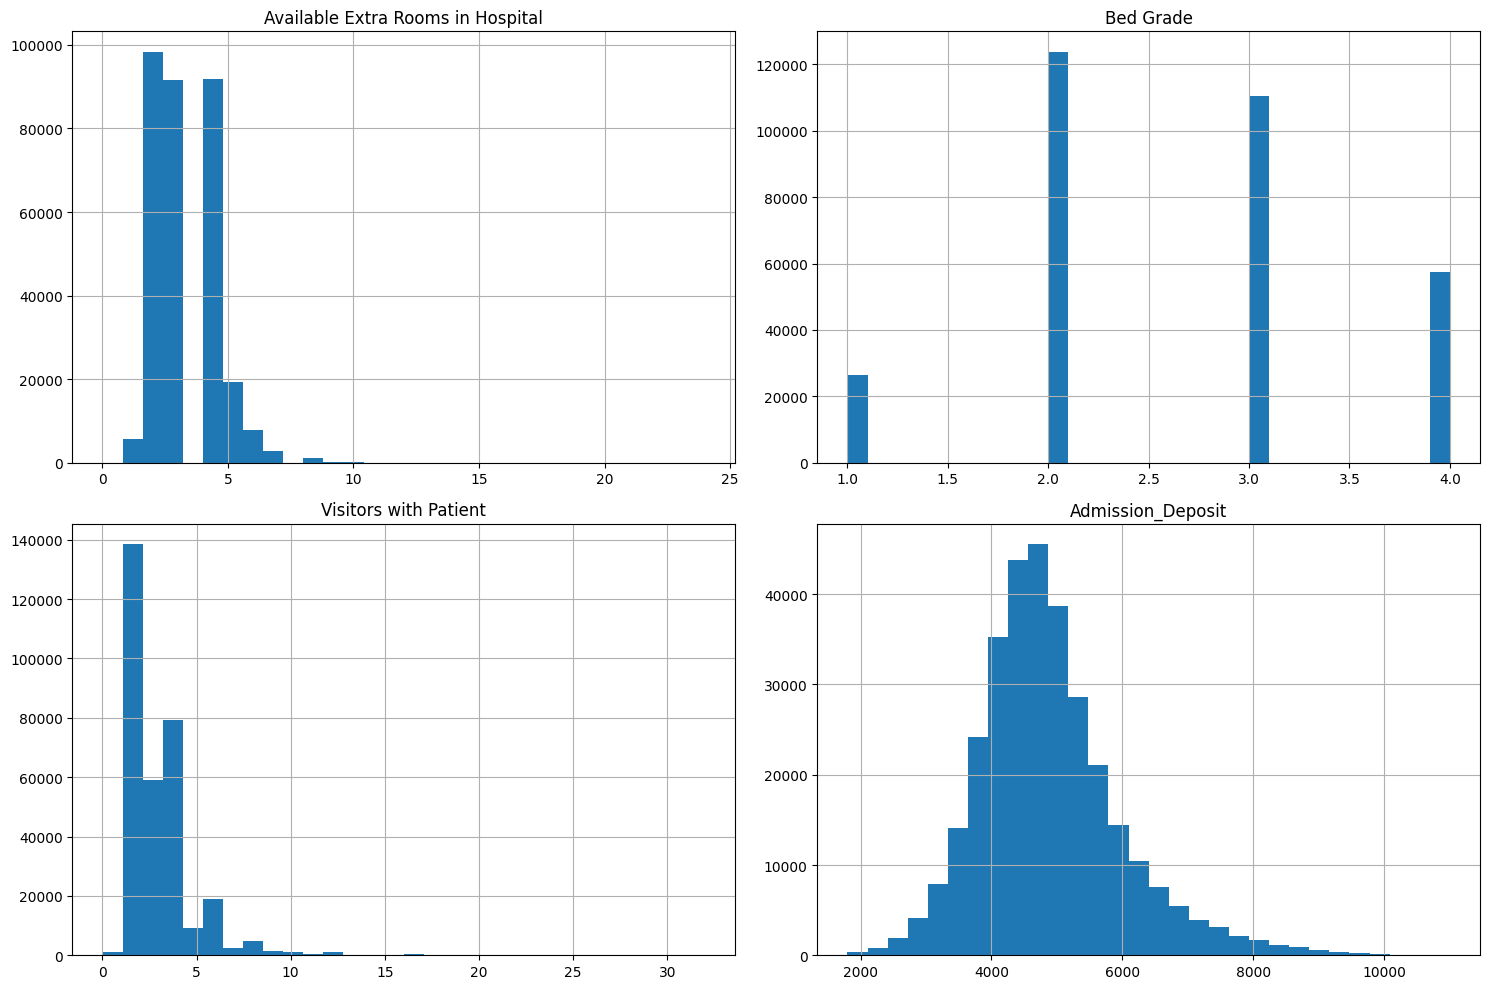

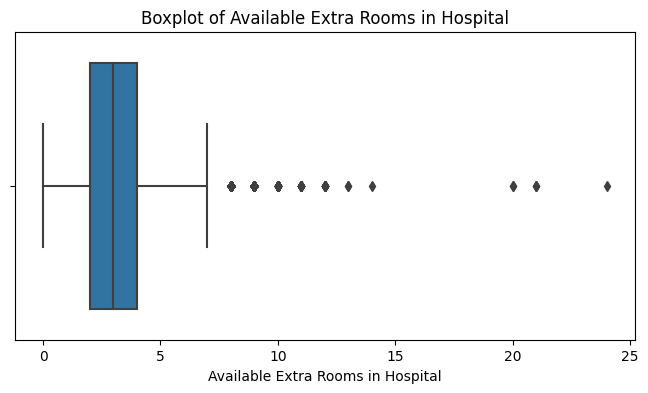

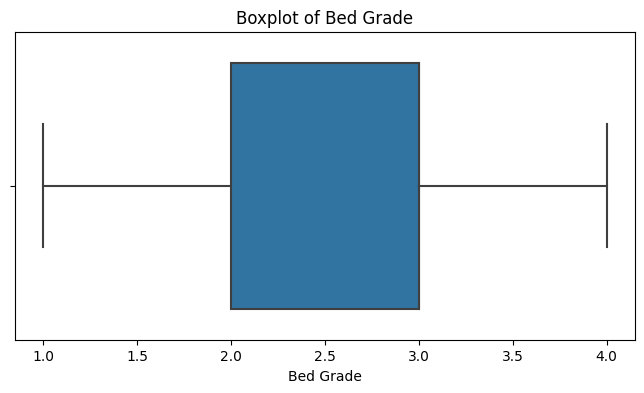

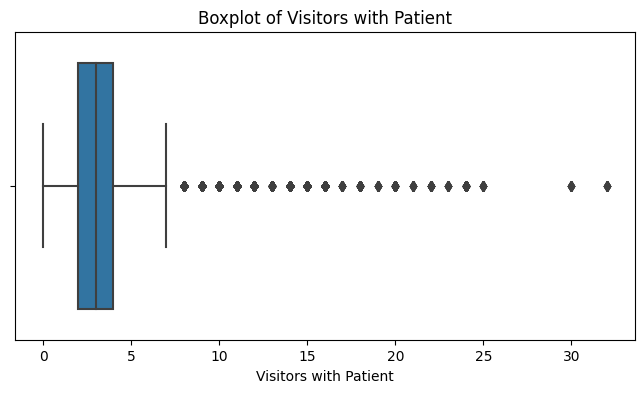

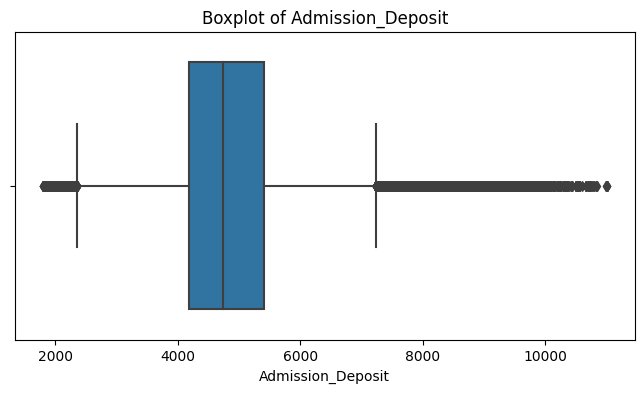

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[numerical_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [16]:
print(data['Available Extra Rooms in Hospital'].describe())

#максимальне значення для Available Extra Rooms in Hospital дорівнює 24, що значно перевищує більшість значень у стовпці (75% значень менше або дорівнюють 4). Це може свідчити про наявність викидів.

count    318438.000000
mean          3.197627
std           1.168171
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          24.000000
Name: Available Extra Rooms in Hospital, dtype: float64


In [17]:
Q1 = data['Available Extra Rooms in Hospital'].quantile(0.25)
Q3 = data['Available Extra Rooms in Hospital'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Lower bound: {lower_bound}')
print(f'Upper bound: {upper_bound}')


Lower bound: -1.0
Upper bound: 7.0


In [18]:
data_cleaned = data[(data['Available Extra Rooms in Hospital'] >= lower_bound) & 
                     (data['Available Extra Rooms in Hospital'] <= upper_bound)]

print(data_cleaned['Available Extra Rooms in Hospital'].describe())

count    317087.000000
mean          3.175431
std           1.117482
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           7.000000
Name: Available Extra Rooms in Hospital, dtype: float64


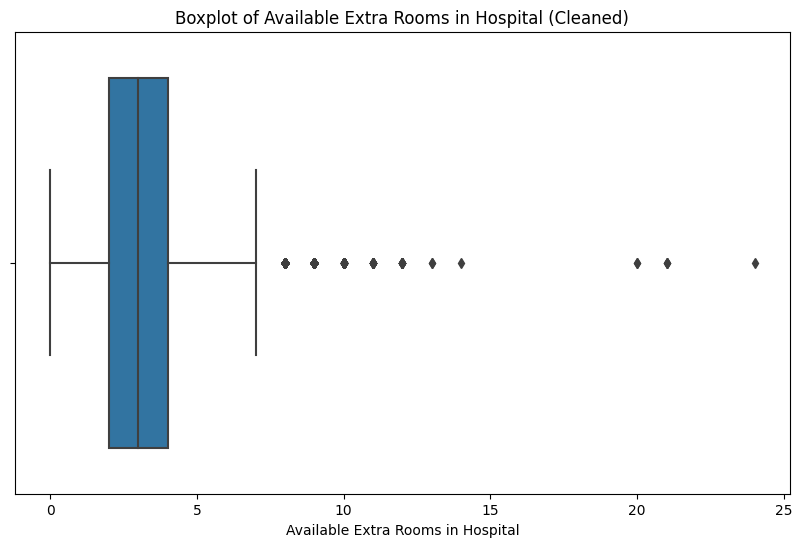

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Available Extra Rooms in Hospital'])
plt.title('Boxplot of Available Extra Rooms in Hospital (Cleaned)')
plt.show()

In [20]:
print(data['Visitors with Patient'].describe())

count    318438.000000
mean          3.284099
std           1.764061
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          32.000000
Name: Visitors with Patient, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


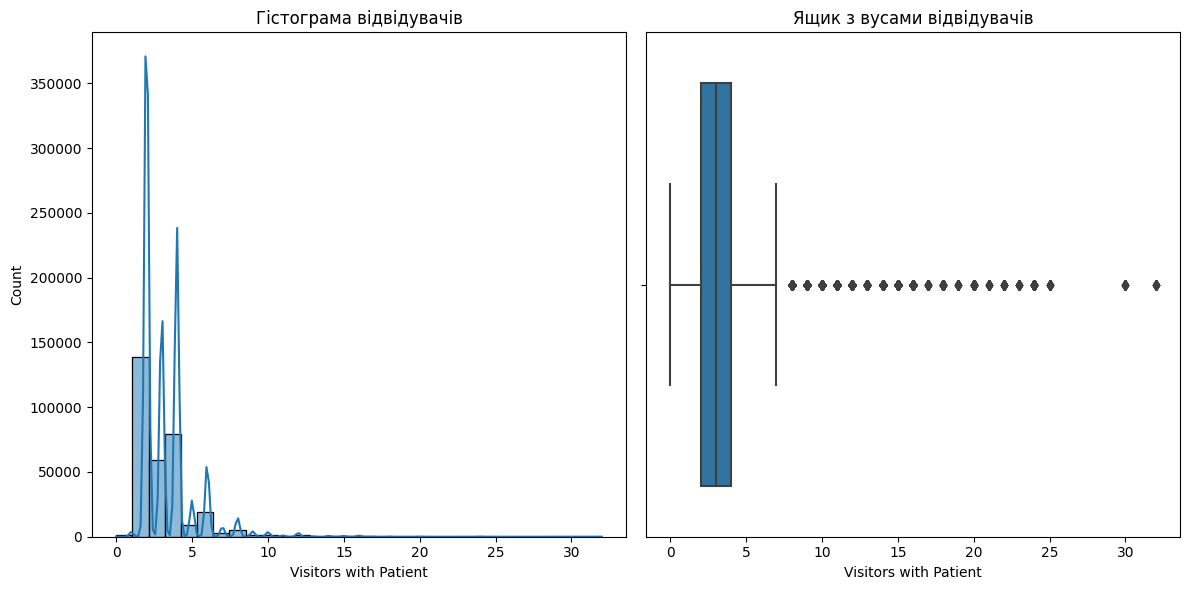

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['Visitors with Patient'], bins=30, kde=True)
plt.title('Гістограма відвідувачів')

plt.subplot(1, 2, 2)
sns.boxplot(x=data['Visitors with Patient'])
plt.title('Ящик з вусами відвідувачів')

plt.tight_layout()
plt.show()

In [22]:
print(data['Admission_Deposit'].describe())

count    318438.000000
mean       4880.749392
std        1086.776254
min        1800.000000
25%        4186.000000
50%        4741.000000
75%        5409.000000
max       11008.000000
Name: Admission_Deposit, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


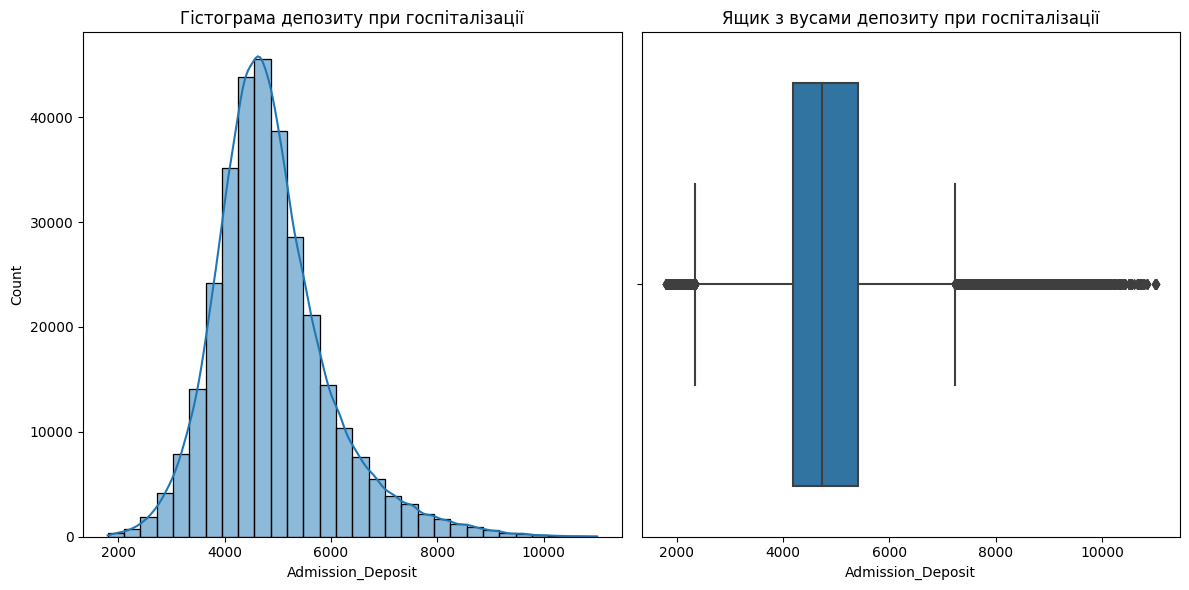

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['Admission_Deposit'], bins=30, kde=True)
plt.title('Гістограма депозиту при госпіталізації')

plt.subplot(1, 2, 2)
sns.boxplot(x=data['Admission_Deposit'])
plt.title('Ящик з вусами депозиту при госпіталізації')

plt.tight_layout()
plt.show()

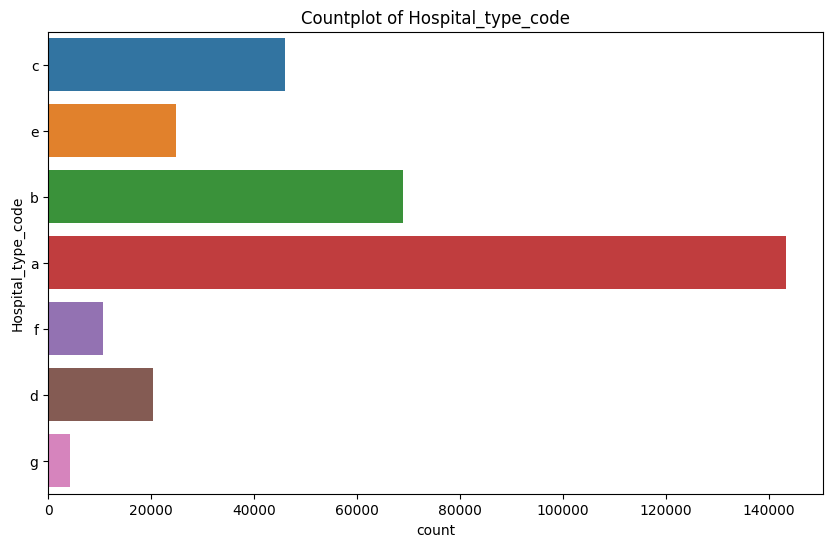

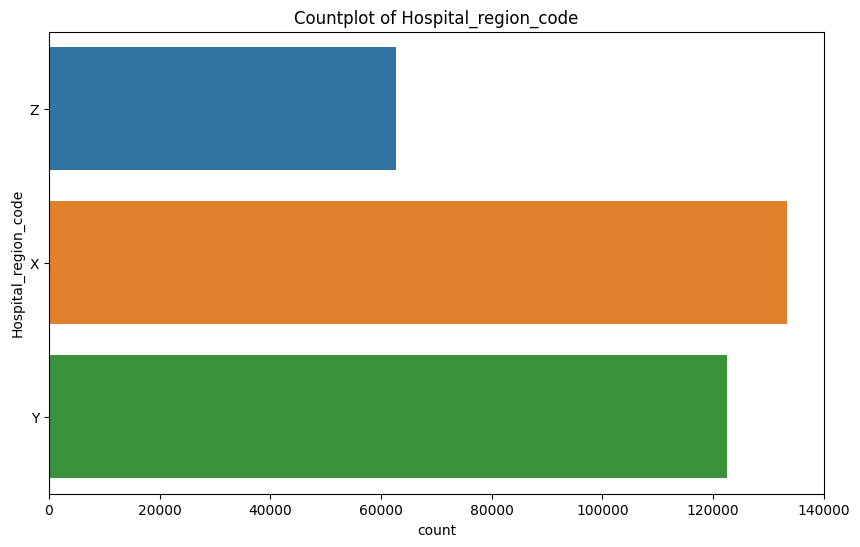

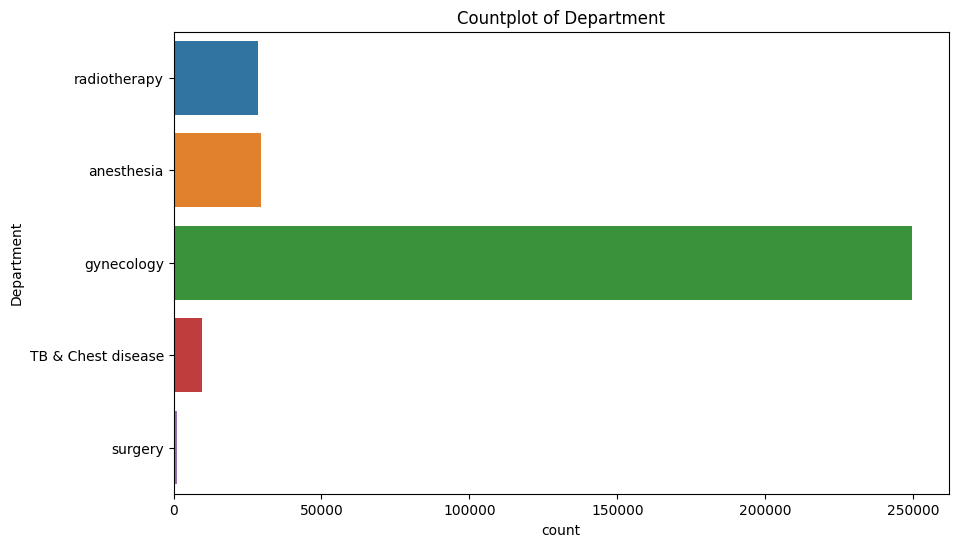

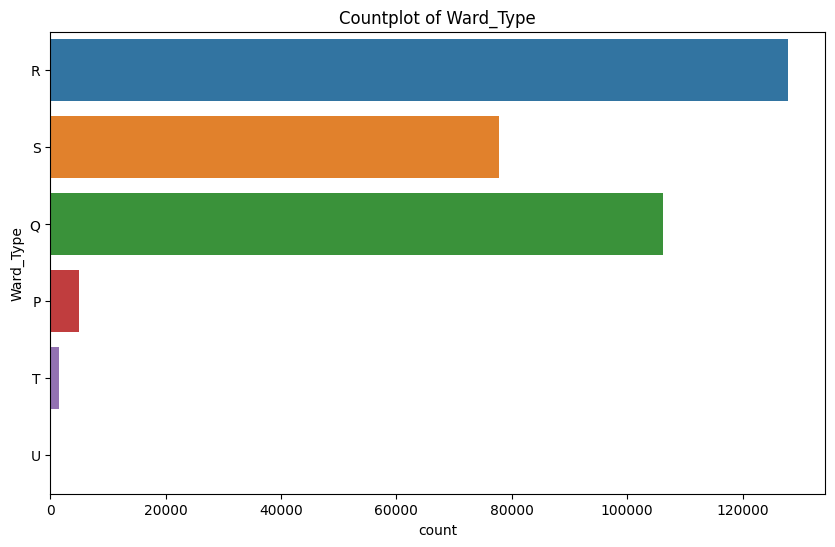

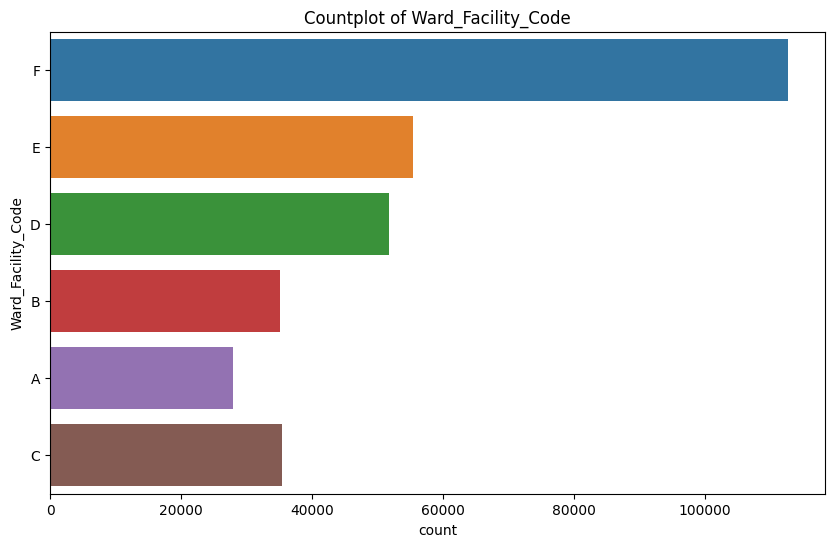

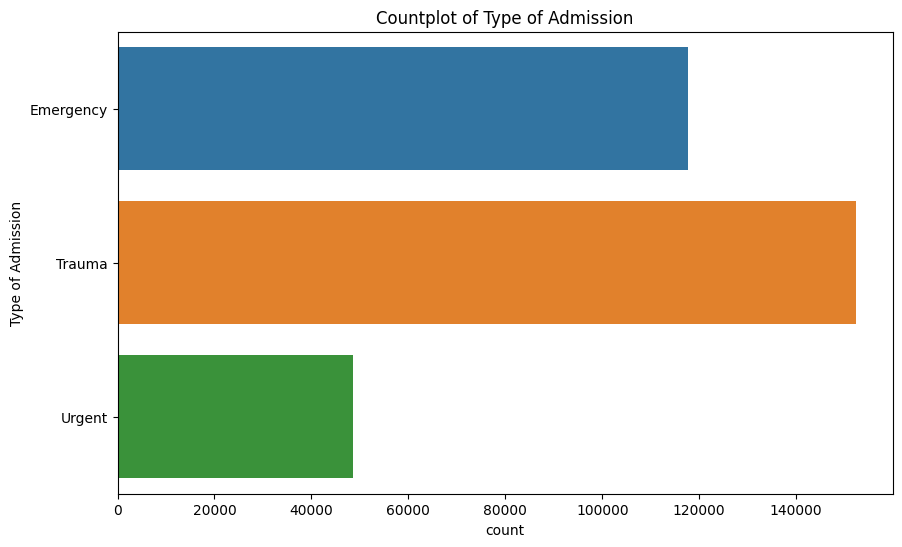

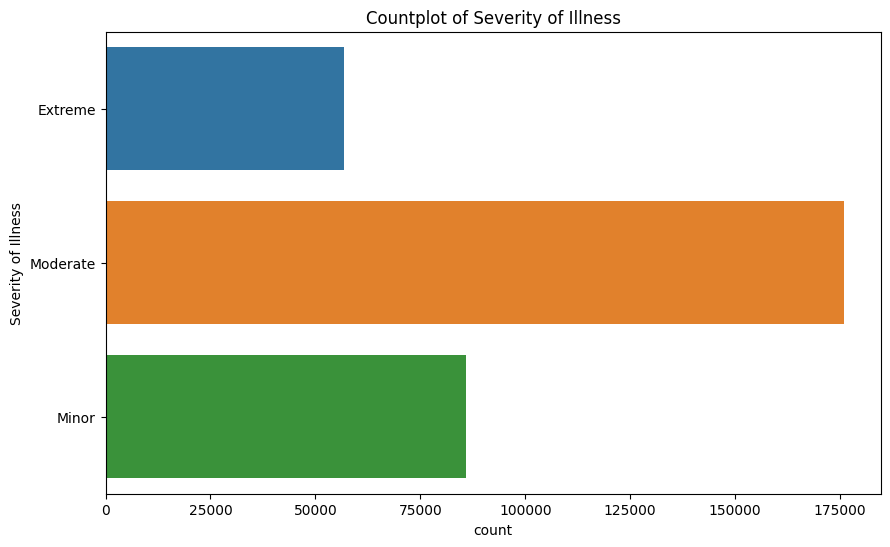

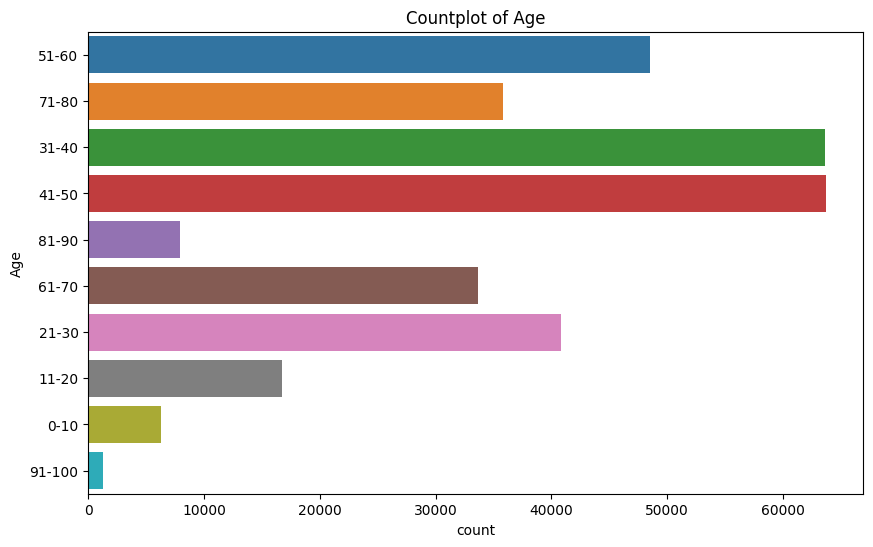

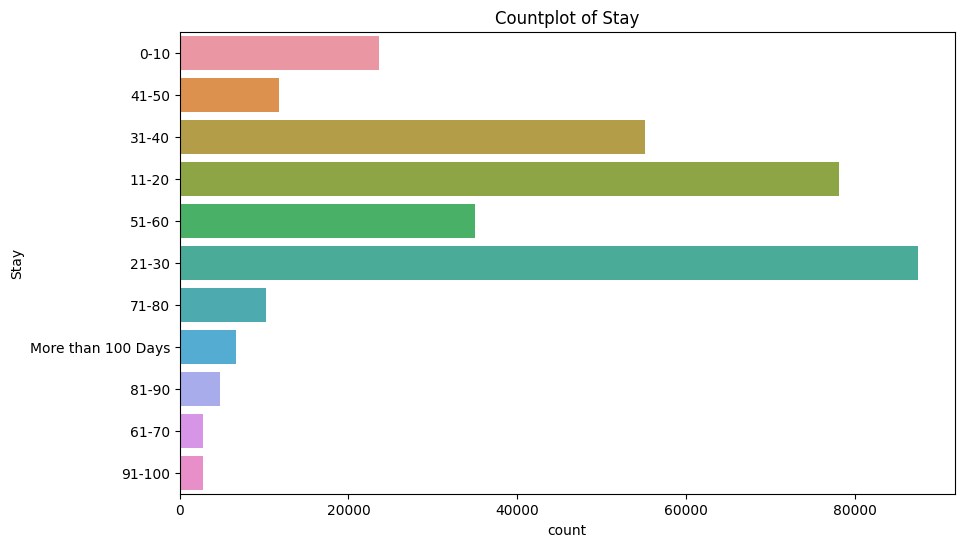

In [24]:
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=data[col])
    plt.title(f'Countplot of {col}')
    plt.show()

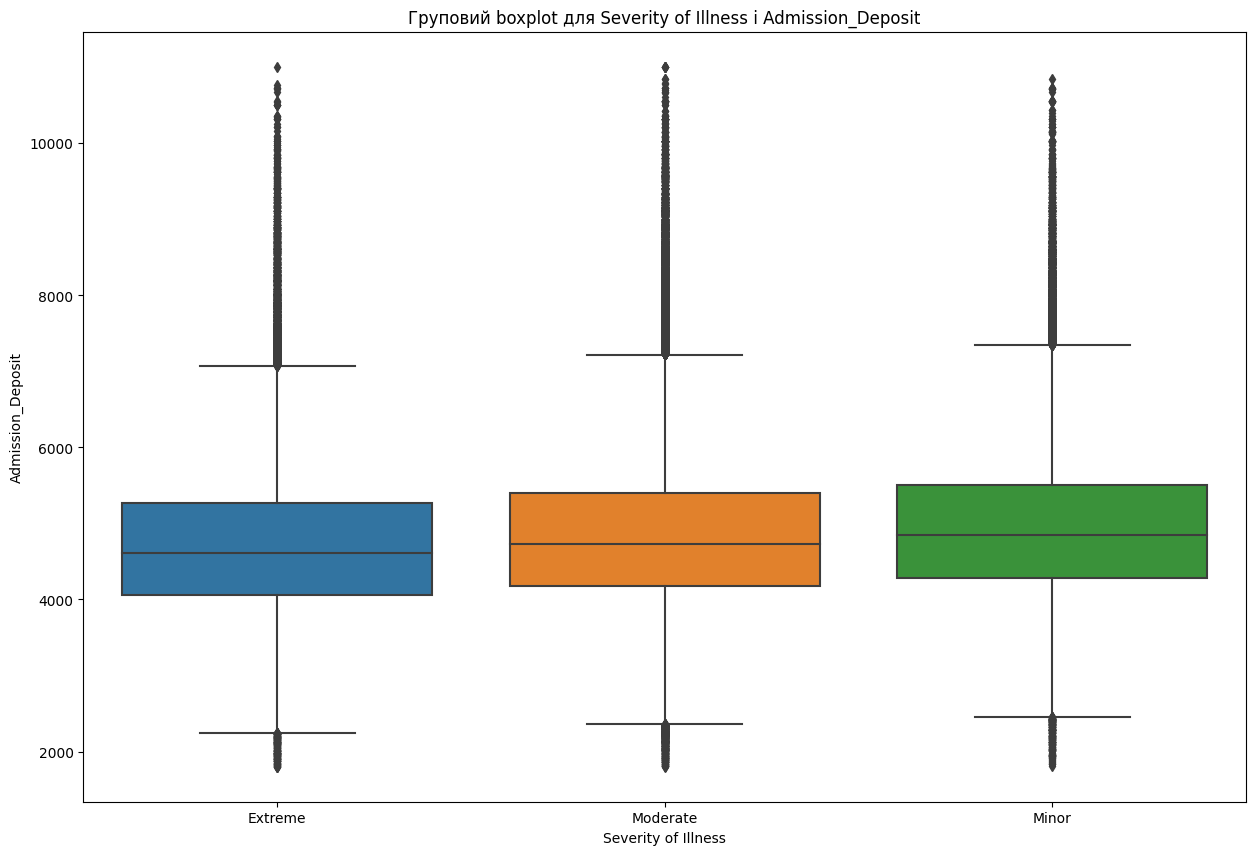

In [25]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='Severity of Illness', y='Admission_Deposit', data=data)
plt.title('Груповий boxplot для Severity of Illness і Admission_Deposit')
plt.show()

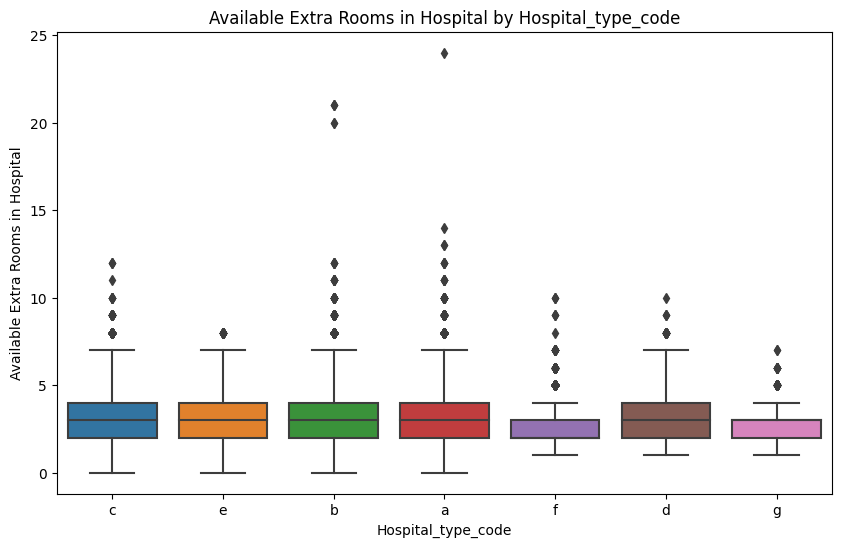

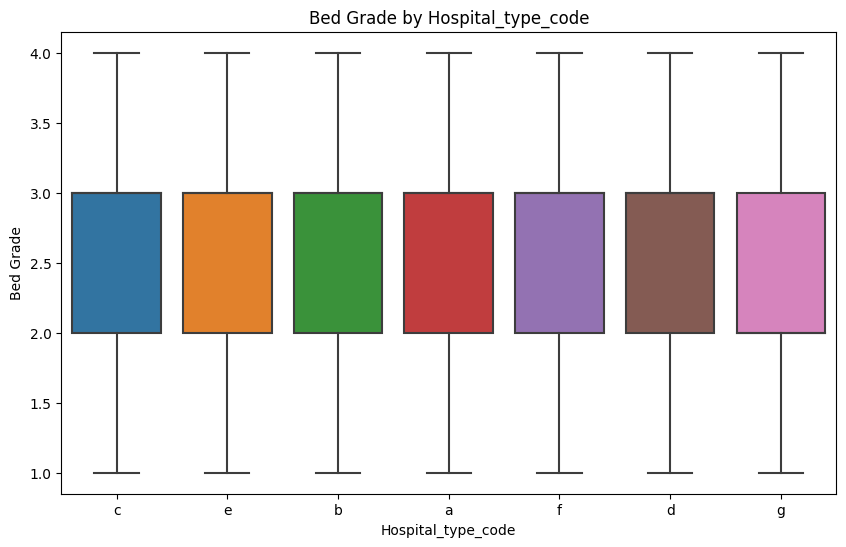

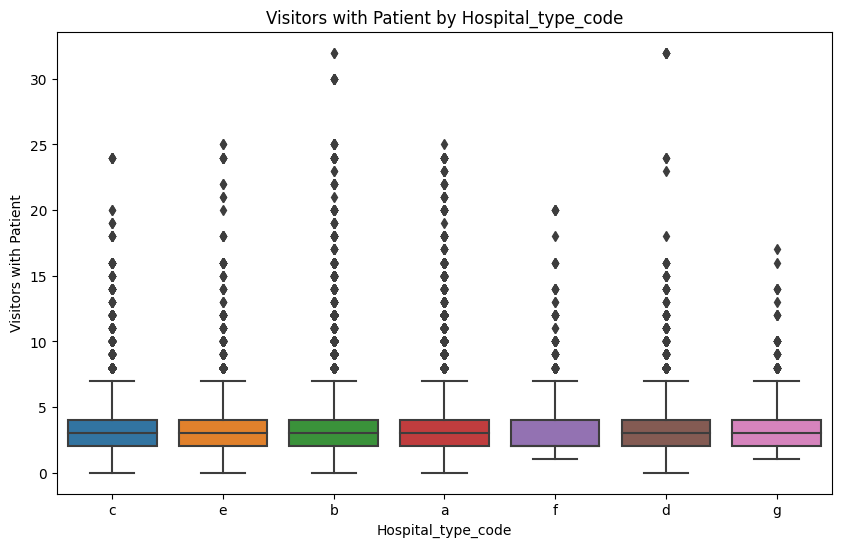

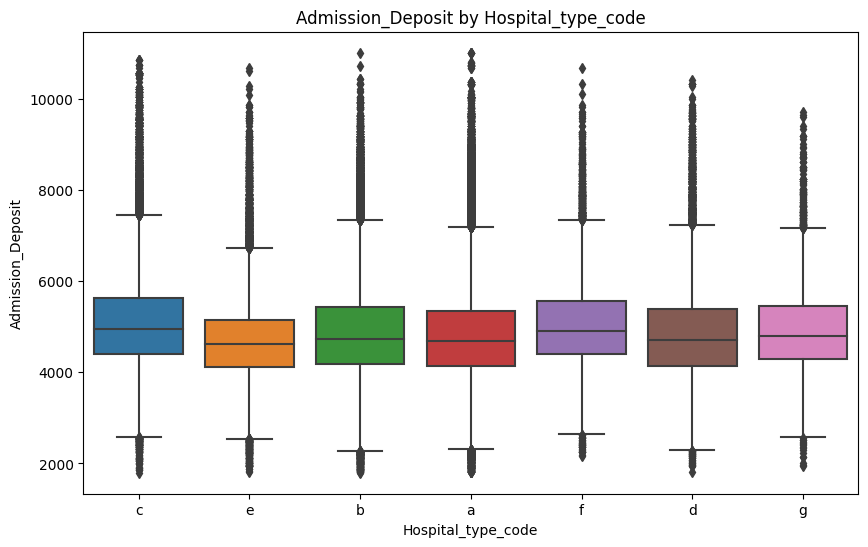

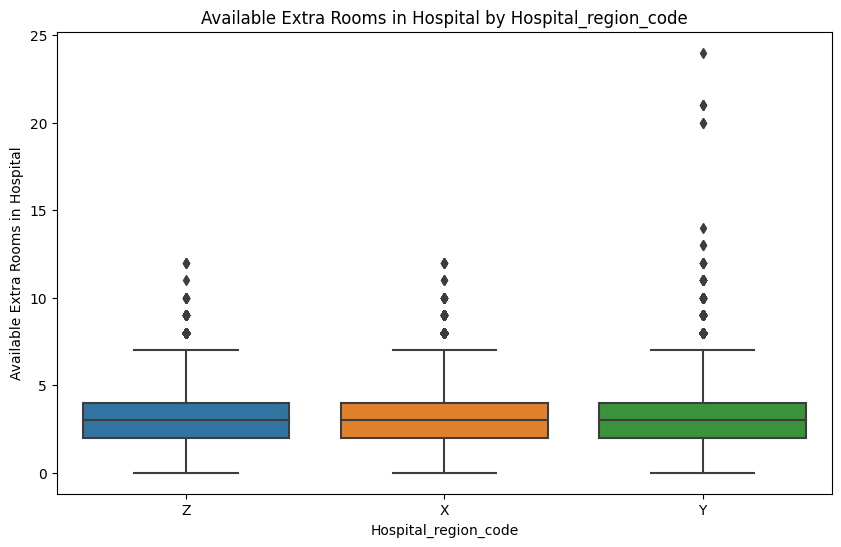

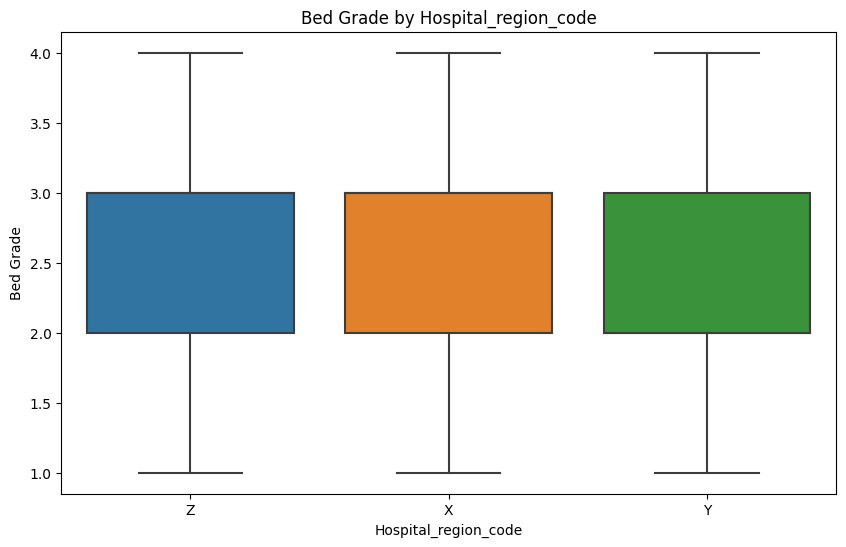

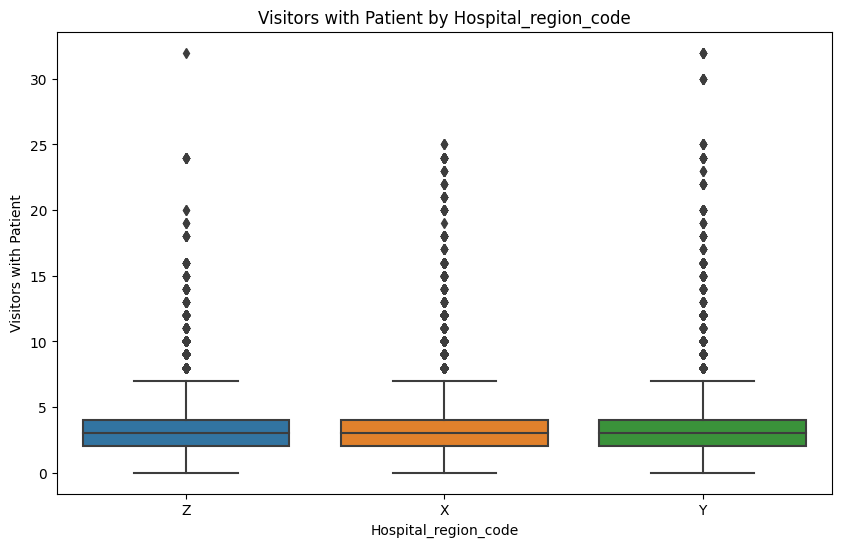

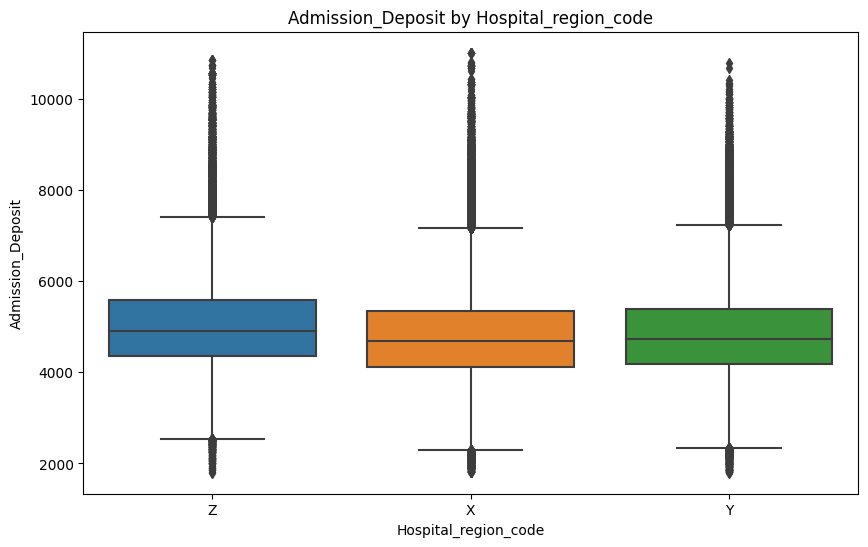

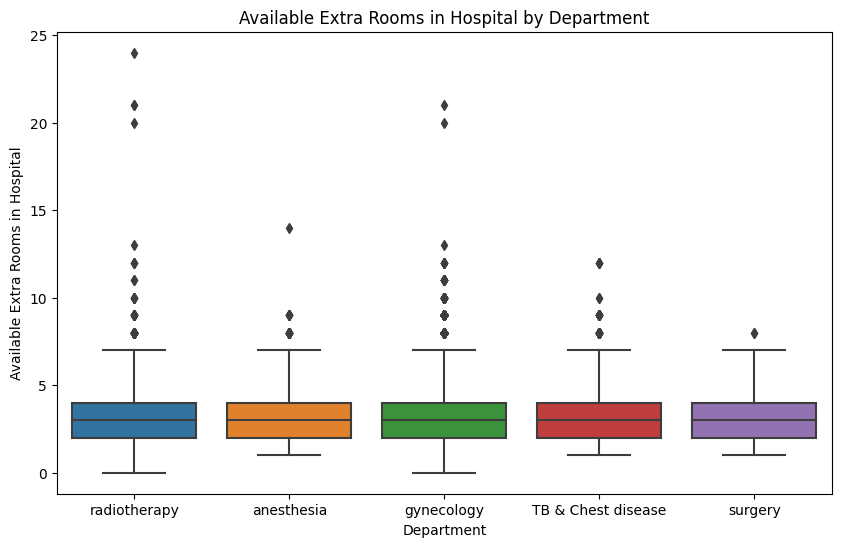

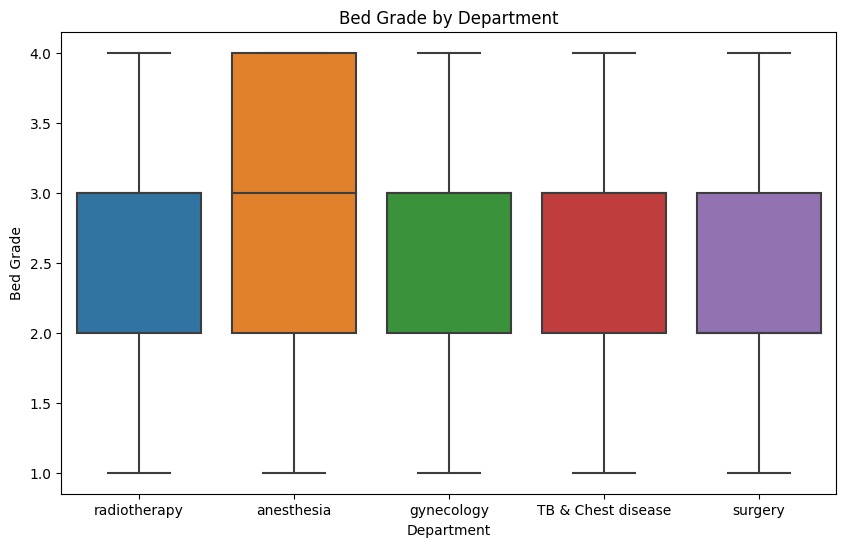

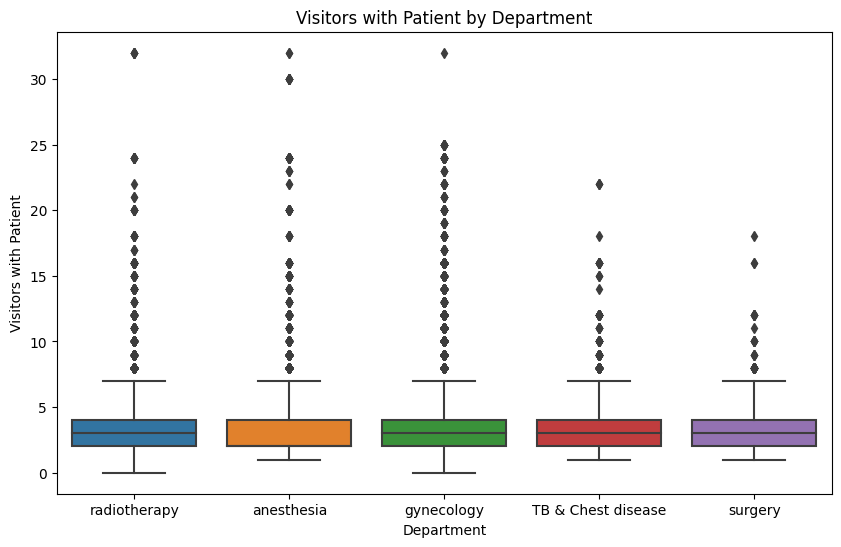

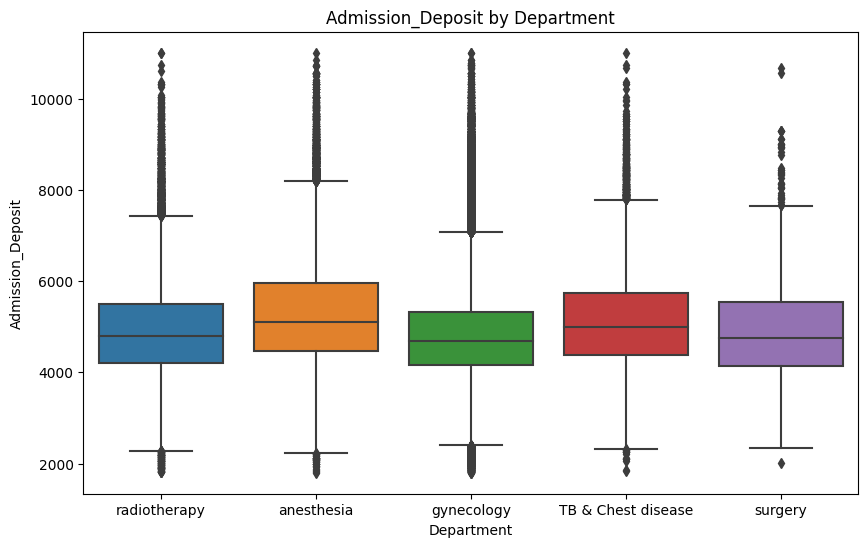

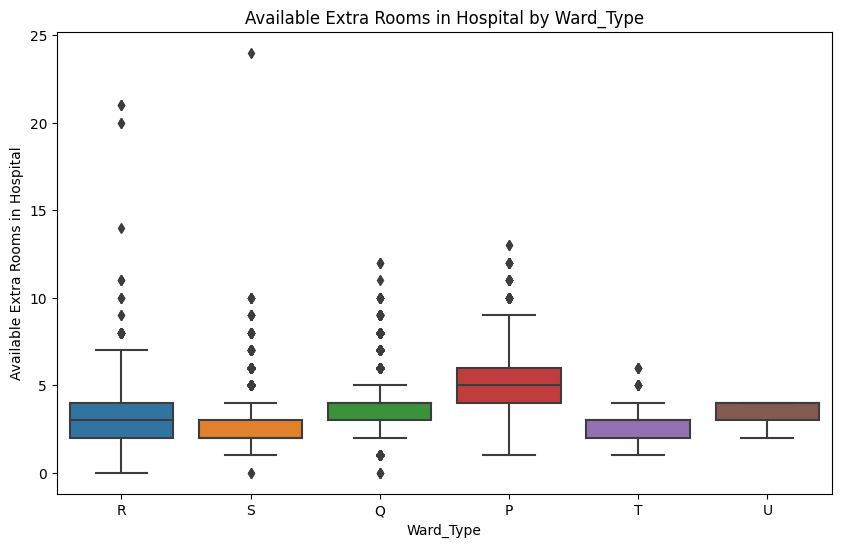

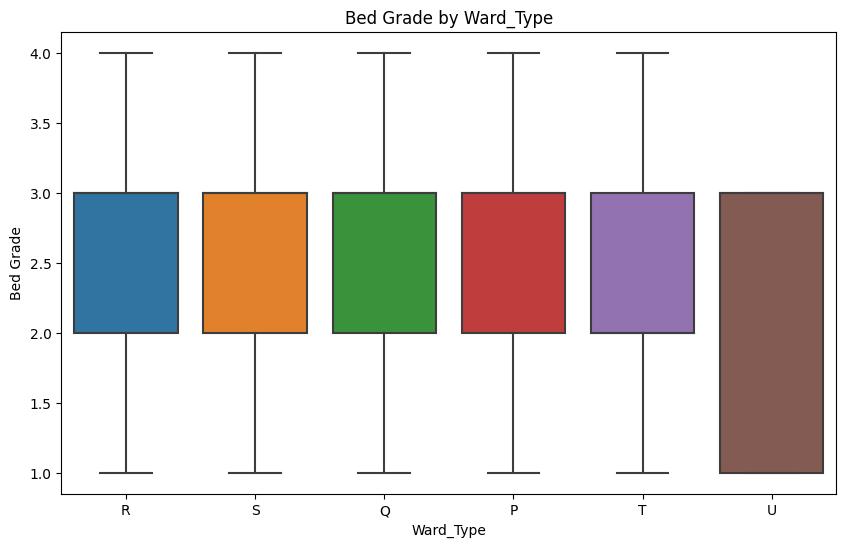

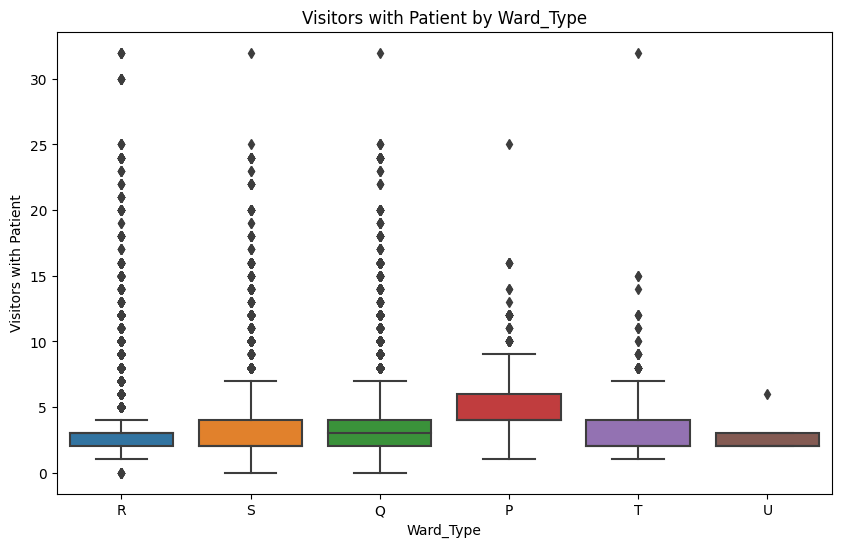

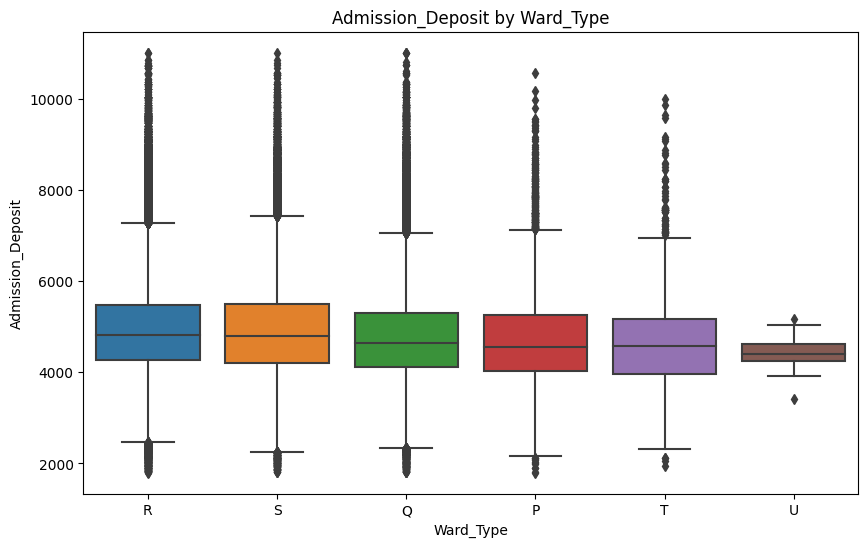

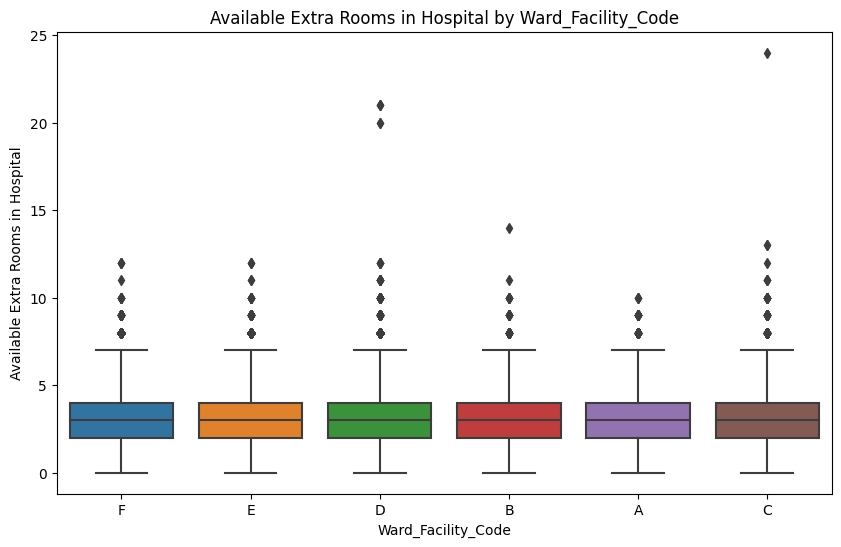

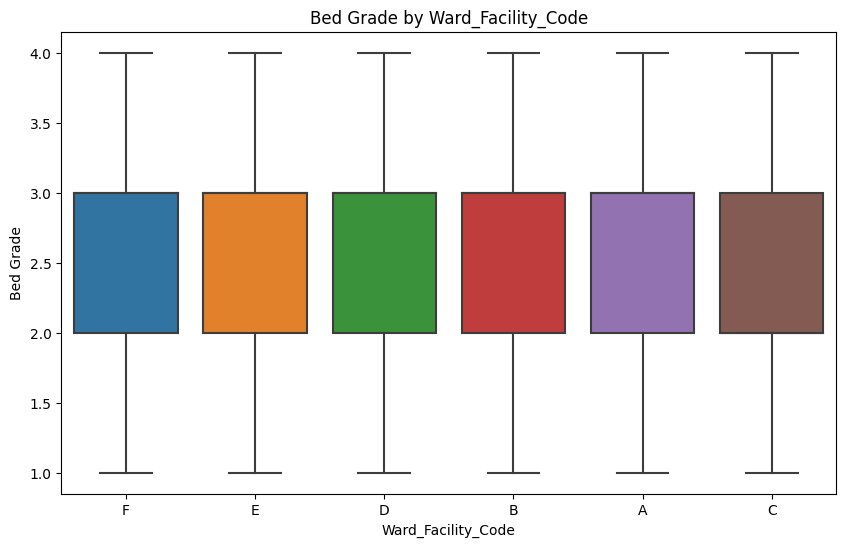

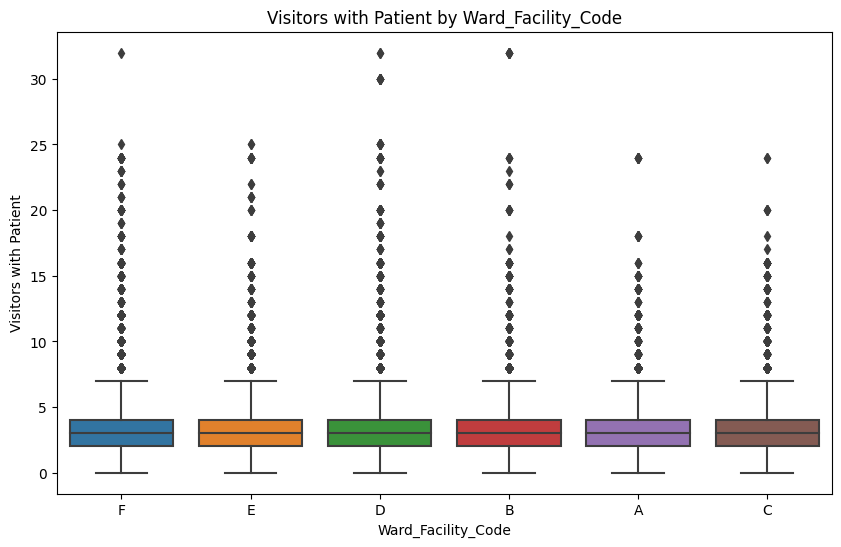

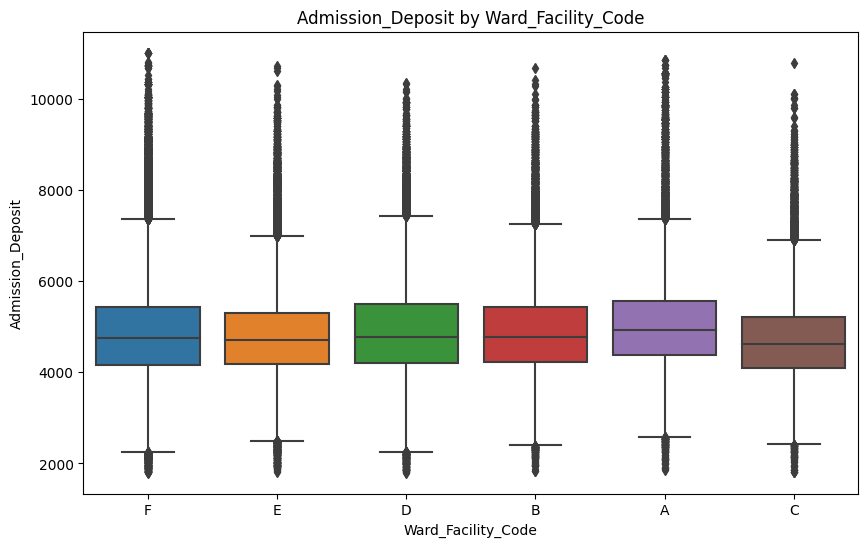

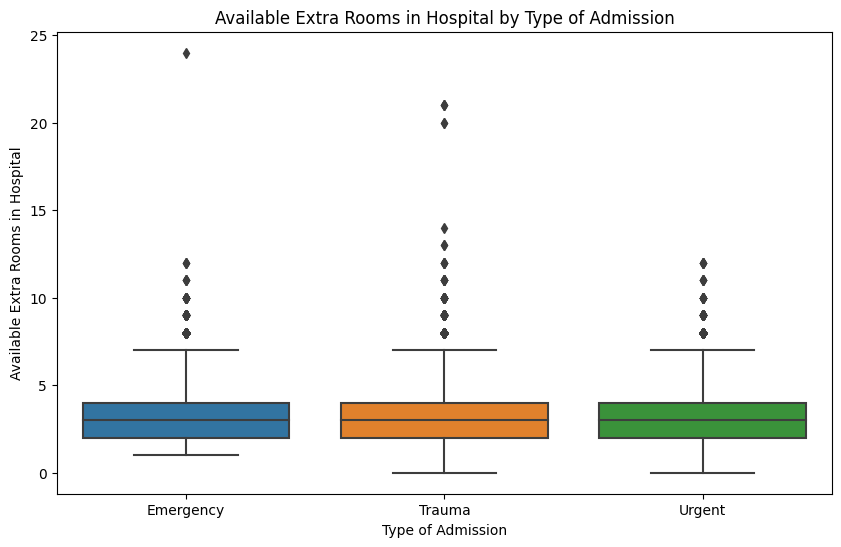

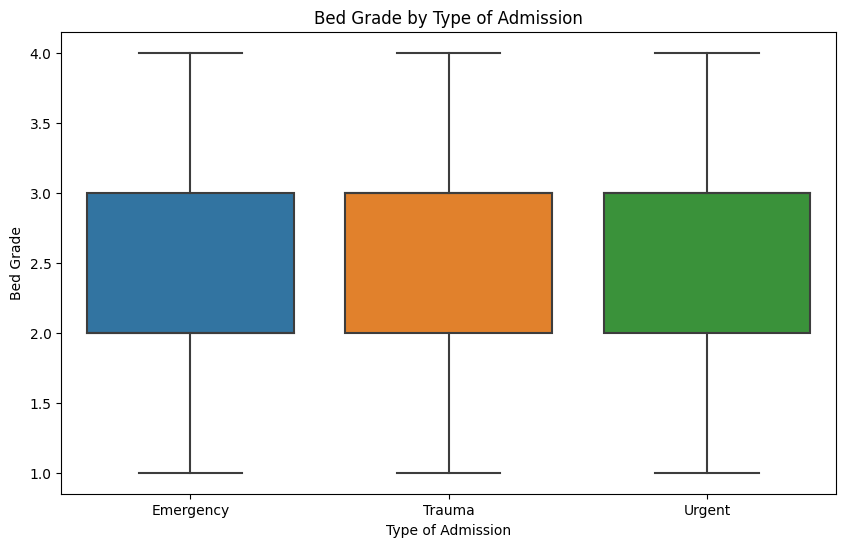

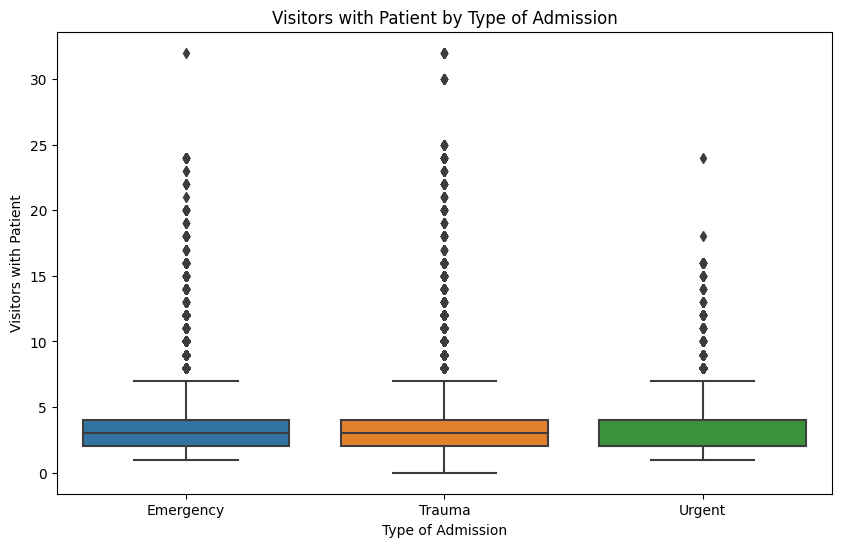

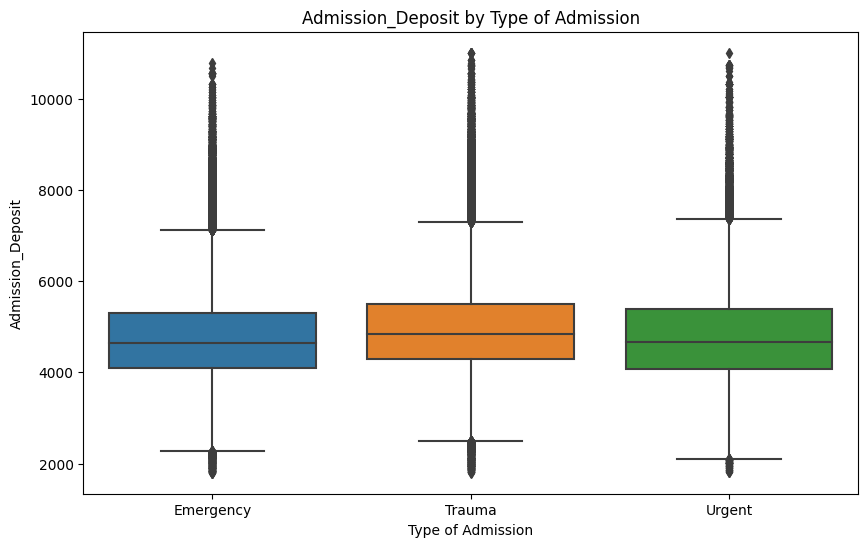

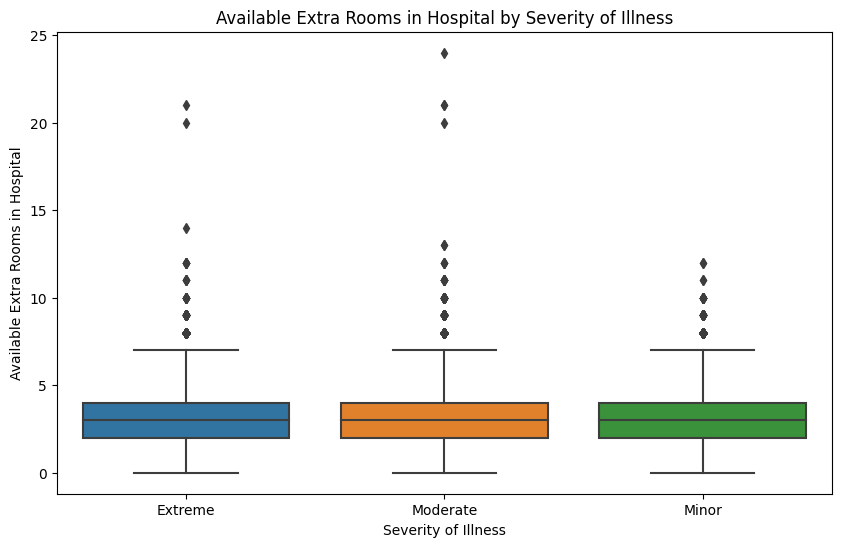

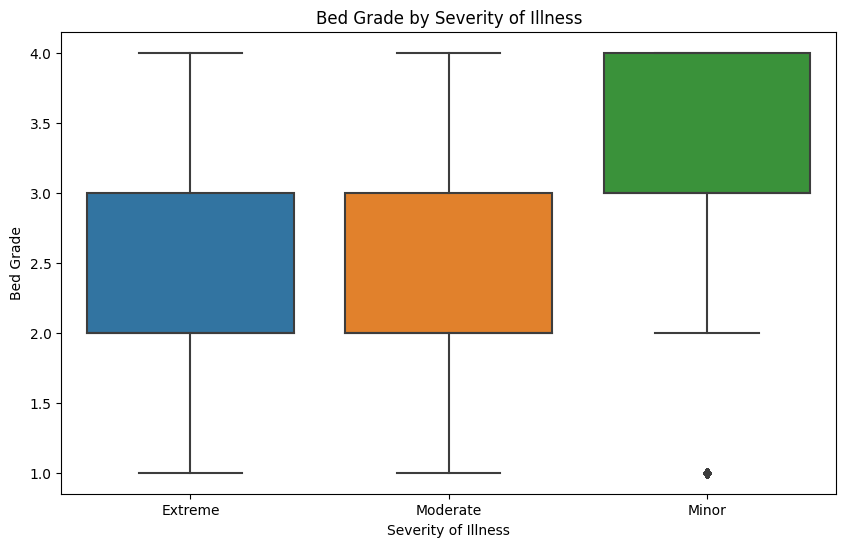

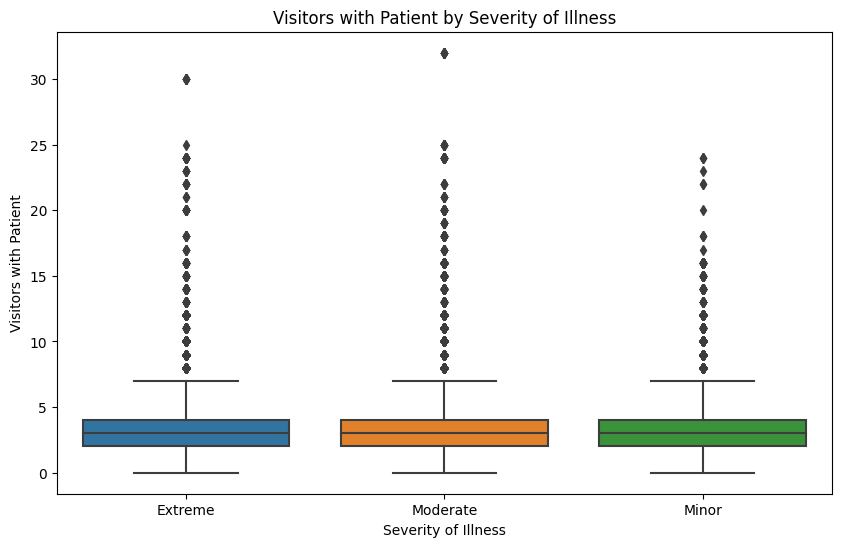

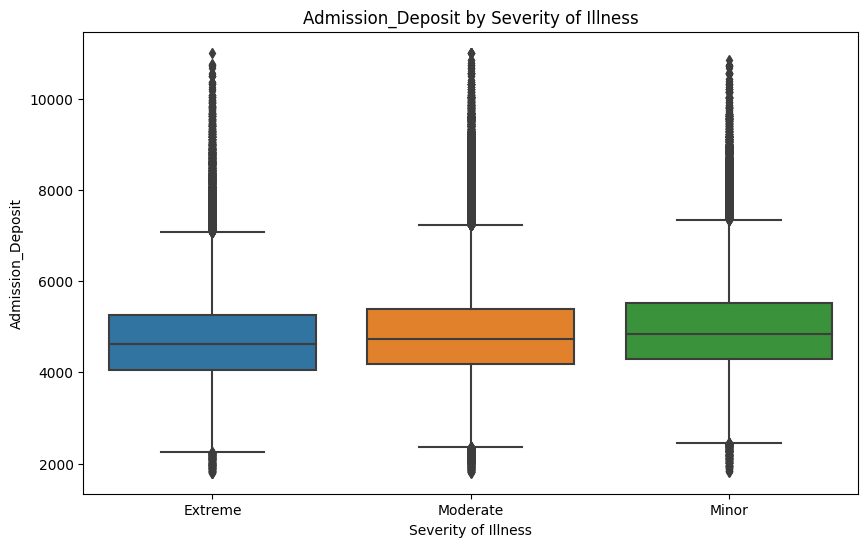

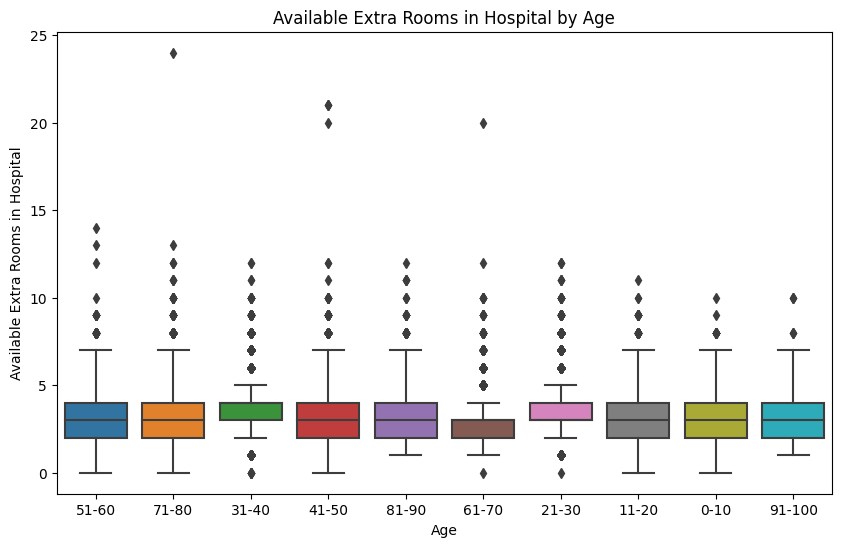

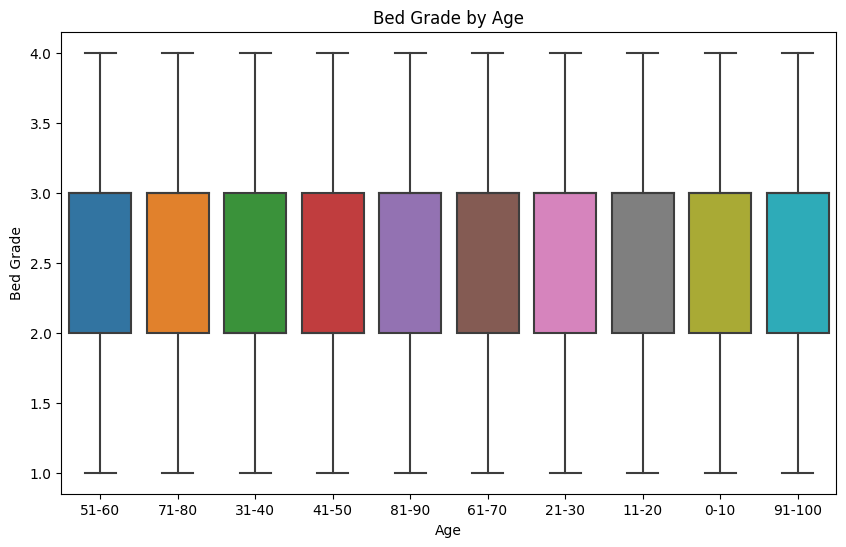

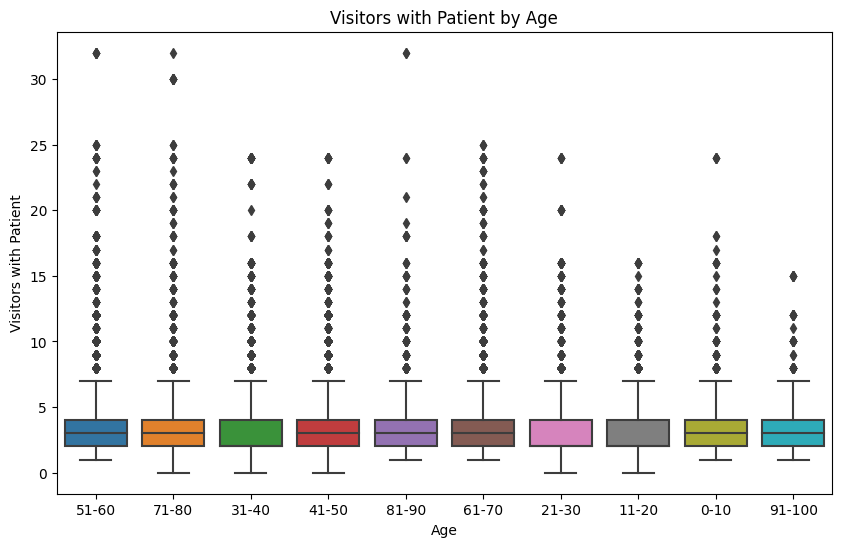

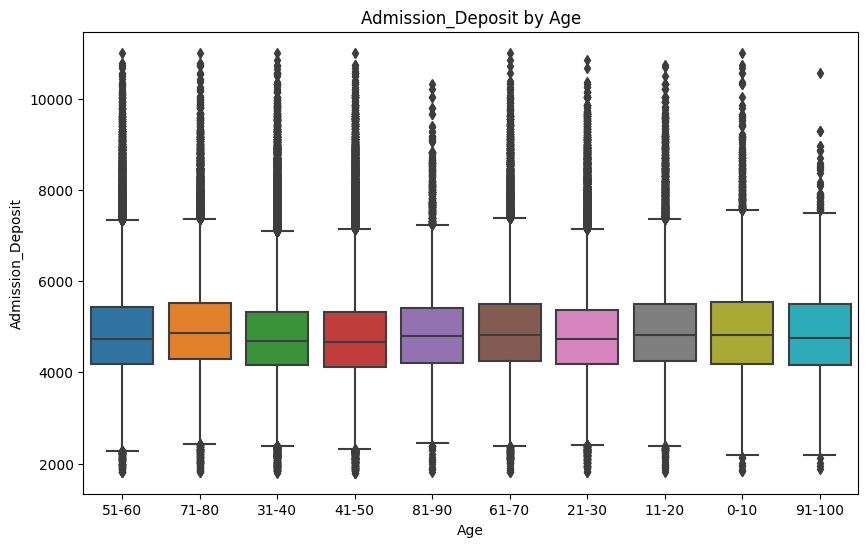

In [26]:
for cat_col in categorical_cols:
    if cat_col != 'Stay':
        for num_col in numerical_cols:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=data[cat_col], y=data[num_col])
            plt.title(f'{num_col} by {cat_col}')
            plt.show()

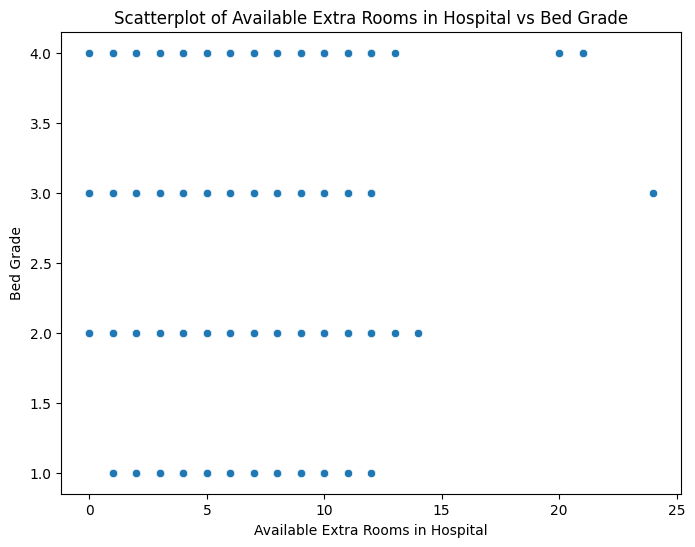

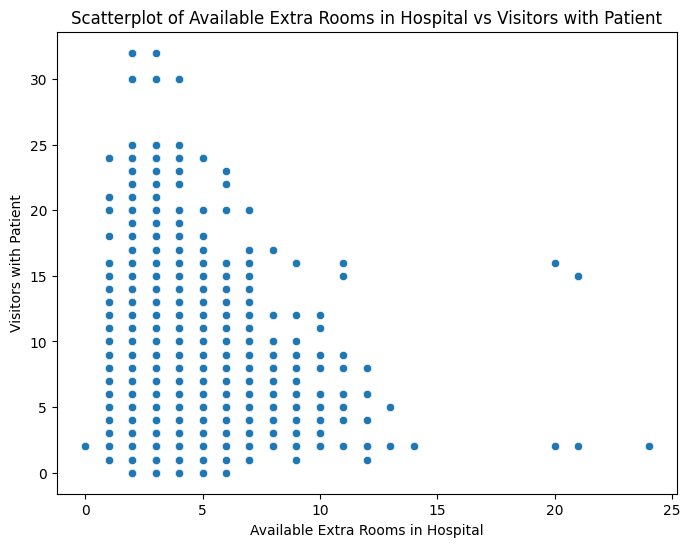

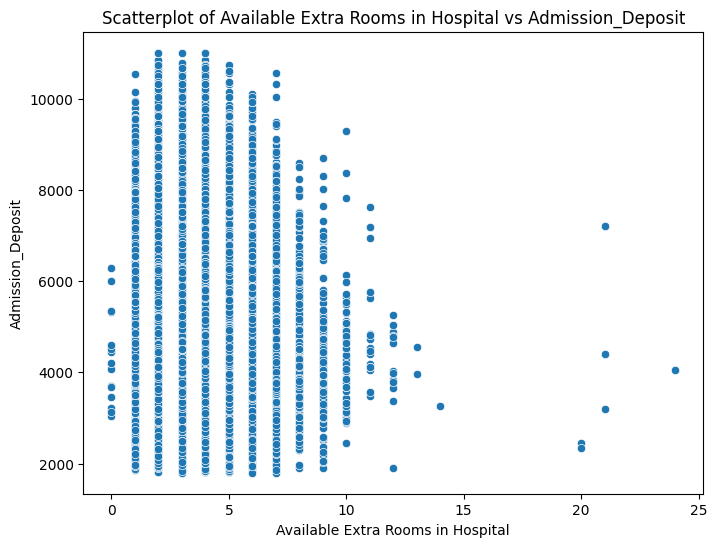

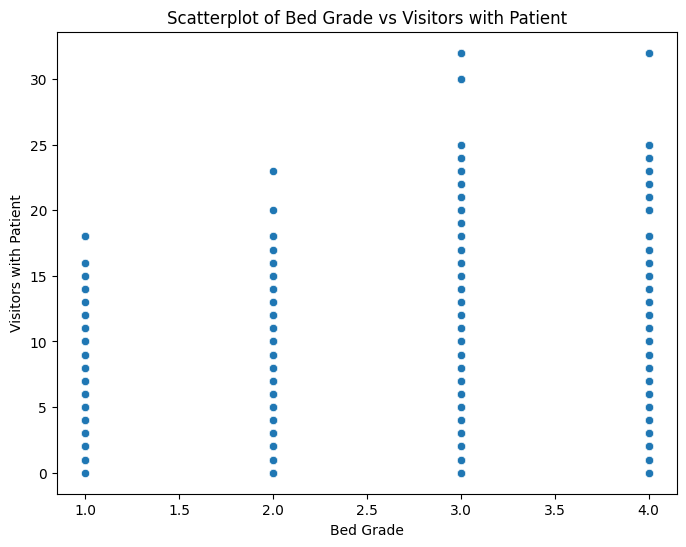

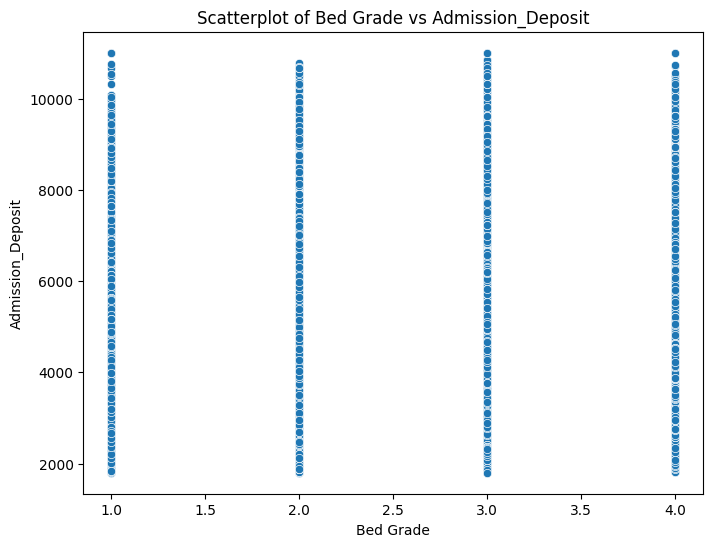

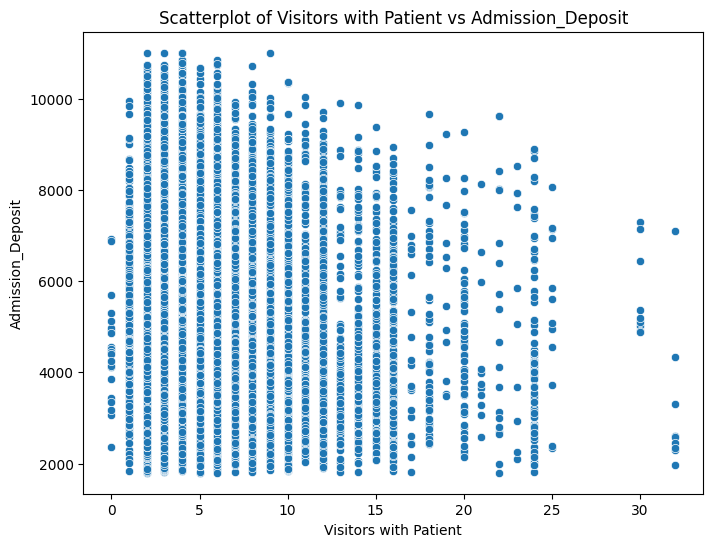

In [27]:
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=data[numerical_cols[i]], y=data[numerical_cols[j]])
        plt.title(f'Scatterplot of {numerical_cols[i]} vs {numerical_cols[j]}')
        plt.xlabel(numerical_cols[i])
        plt.ylabel(numerical_cols[j])
        plt.show()

In [28]:
import pandas as pd

data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

data['Age'].fillna(data['Age'].median(), inplace=True)

def categorize_age(age):
    if age <= 18:
        return 'Молодший'
    elif 19 <= age <= 65:
        return 'Середній'
    else:
        return 'Старший'

data['Age_Category'] = data['Age'].apply(categorize_age)

def categorize_deposit(deposit):
    if deposit < 3000:
        return 'Низький'
    elif 3000 <= deposit <= 6000:
        return 'Середній'
    else:
        return 'Високий'

data['Deposit_Category'] = data['Admission_Deposit'].apply(categorize_deposit)

print(data[['Age', 'Age_Category', 'Admission_Deposit', 'Deposit_Category']].head())

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/tmp/ipykernel_36/1523251480.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)


   Age Age_Category  Admission_Deposit Deposit_Category
0  NaN      Старший             4911.0         Середній
1  NaN      Старший             5954.0         Середній
2  NaN      Старший             4745.0         Середній
3  NaN      Старший             7272.0          Високий
4  NaN      Старший             5558.0         Середній


In [29]:
import pandas as pd

def calculate_stay_days(stay_range):
    try:
        min_days, max_days = map(int, stay_range.split('-'))
        return (min_days + max_days) / 2
    except ValueError:
        if 'More than 100 Days' in stay_range:
            return 100  
        return None

data['Stay_Days'] = data['Stay'].apply(calculate_stay_days)

In [30]:
from sklearn.model_selection import train_test_split

features = data.drop(columns=['Stay', 'Stay_Days'])
target = data['Stay_Days']

features = pd.get_dummies(features)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), X_train.columns)
    ]
)

In [32]:
print(data['Stay_Days'].isnull().sum())

0


In [33]:
mean_stay_days = data['Stay_Days'].mean()
data['Stay_Days'].fillna(mean_stay_days, inplace=True)

In [34]:
print(data['Stay_Days'].isnull().sum())

0


In [35]:
print(f"NaN in y_train: {y_train.isnull().sum()}")
print(f"NaN in y_test: {y_test.isnull().sum()}")

NaN in y_train: 0
NaN in y_test: 0


In [36]:
mean_y_train = y_train.mean()
mean_y_test = y_test.mean()

y_train.fillna(mean_y_train, inplace=True)
y_test.fillna(mean_y_test, inplace=True)

In [37]:
print(f"NaN in y_train after cleaning: {y_train.isnull().sum()}")
print(f"NaN in y_test after cleaning: {y_test.isnull().sum()}")

NaN in y_train after cleaning: 0
NaN in y_test after cleaning: 0


In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [39]:
y_pred

array([26.88 , 41.445, 31.4  , ..., 31.9  , 22.765, 22.65 ])

In [40]:
y_pred = model.predict(X_test)

results = pd.DataFrame({
    'Actual Stay': y_test,
    'Predicted Stay': y_pred
})

print(results.head(10))

        Actual Stay  Predicted Stay
245328         55.5          26.880
239123         55.5          41.445
280646         25.5          31.400
89025          25.5          30.880
517            35.5          20.565
275285         35.5          22.405
221020        100.0          43.100
297989         15.5          18.130
128961          5.0          27.770
208348         15.5          20.815


In [41]:
print("Actual Stay Statistics:")
print(y_test.describe())

print("Predicted Stay Statistics:")
print(pd.Series(y_pred).describe())

Actual Stay Statistics:
count    63688.000000
mean        32.315177
std         21.059867
min          5.000000
25%         15.500000
50%         25.500000
75%         35.500000
max        100.000000
Name: Stay_Days, dtype: float64
Predicted Stay Statistics:
count    63688.000000
mean        32.502264
std         15.562201
min          5.615000
25%         22.195000
50%         27.095000
75%         39.100000
max        100.000000
dtype: float64


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_pred = model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train RMSE: {train_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Train R^2: {train_r2}")

test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print("")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {test_r2}")

Train RMSE: 5.9308626037270065
Train MAE: 4.2866414078072195
Train R^2: 0.9216923571752751

Test RMSE: 15.741012822226171
Test MAE: 11.467699184099121
Test R^2: 0.4413228546979707


In [43]:
import lightgbm as lgb

lgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

lgb_rmse = mean_squared_error(y_test, y_pred_lgb, squared=False)
lgb_mae = mean_absolute_error(y_test, y_pred_lgb)
lgb_r2 = r2_score(y_test, y_pred_lgb)

print(f"LightGBM RMSE: {lgb_rmse}")
print(f"LightGBM MAE: {lgb_mae}")
print(f"LightGBM R^2: {lgb_r2}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
LightGBM RMSE: 15.16202540709401
LightGBM MAE: 10.954781480201186
LightGBM R^2: 0.4816656385267013


In [44]:
!pip install -q optuna

In [45]:
import optuna

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)
    }

    lgb_model = lgb.LGBMRegressor(**param, random_state=42)
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', lgb_model)
    ])

    model_pipeline.fit(X_train, y_train)
    y_pred_optuna = model_pipeline.predict(X_test)
    return mean_squared_error(y_test, y_pred_optuna, squared=False)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f"Best parameters: {study.best_params}")

[I 2024-09-04 19:24:32,401] A new study created in memory with name: no-name-e510c1f4-7973-44f4-9c86-3d4ce7d54088
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.360224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:25:13,557] Trial 0 finished with value: 15.321231481074834 and parameters: {'n_estimators': 376, 'max_depth': 10, 'learning_rate': 0.012348712267219434}. Best is trial 0 with value: 15.321231481074834.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.347919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2024-09-04 19:25:49,027] Trial 1 finished with value: 15.262295204482939 and parameters: {'n_estimators': 432, 'max_depth': 5, 'learning_rate': 0.021186436358587604}. Best is trial 1 with value: 15.262295204482939.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:26:17,264] Trial 2 finished with value: 15.505507890923552 and parameters: {'n_estimators': 226, 'max_depth': 7, 'learning_rate': 0.01304782146285566}. Best is trial 1 with value: 15.262295204482939.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:26:34,468] Trial 3 finished with value: 15.155103836004328 and parameters: {'n_estimators': 149, 'max_depth': 6, 'learning_rate': 0.09270312811166552}. Best is trial 3 with value: 15.155103836004328.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:26:59,378] Trial 4 finished with value: 15.10686565957112 and parameters: {'n_estimators': 309, 'max_depth': 9, 'learning_rate': 0.08342181024677131}. Best is trial 4 with value: 15.10686565957112.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.324310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2024-09-04 19:27:17,606] Trial 5 finished with value: 15.364553023158356 and parameters: {'n_estimators': 138, 'max_depth': 5, 'learning_rate': 0.04175329083904089}. Best is trial 4 with value: 15.10686565957112.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.326324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:27:39,392] Trial 6 finished with value: 15.191916220840477 and parameters: {'n_estimators': 169, 'max_depth': 9, 'learning_rate': 0.048166801549131284}. Best is trial 4 with value: 15.10686565957112.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.355439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 19:28:03,902] Trial 7 finished with value: 15.747562985961727 and parameters: {'n_estimators': 235, 'max_depth': 4, 'learning_rate': 0.012646075436246292}. Best is trial 4 with value: 15.10686565957112.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.347209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 19:28:18,321] Trial 8 finished with value: 15.441675755421423 and parameters: {'n_estimators': 146, 'max_depth': 3, 'learning_rate': 0.09807726311934041}. Best is trial 4 with value: 15.10686565957112.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:28:41,871] Trial 9 finished with value: 15.121236243817602 and parameters: {'n_estimators': 260, 'max_depth': 7, 'learning_rate': 0.07327752913427717}. Best is trial 4 with value: 15.10686565957112.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:29:18,300] Trial 10 finished with value: 15.17686792696096 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.02564077964242445}. Best is trial 4 with value: 15.10686565957112.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:29:44,779] Trial 11 finished with value: 15.116306597718571 and parameters: {'n_estimators': 308, 'max_depth': 8, 'learning_rate': 0.06554590780160943}. Best is trial 4 with value: 15.10686565957112.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.339850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:30:14,462] Trial 12 finished with value: 15.115483296652616 and parameters: {'n_estimators': 341, 'max_depth': 8, 'learning_rate': 0.05709239493259011}. Best is trial 4 with value: 15.10686565957112.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.354455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:30:49,994] Trial 13 finished with value: 15.106126298364304 and parameters: {'n_estimators': 469, 'max_depth': 10, 'learning_rate': 0.050058052820747774}. Best is trial 13 with value: 15.106126298364304.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:31:03,735] Trial 14 finished with value: 15.73108047246621 and parameters: {'n_estimators': 52, 'max_depth': 10, 'learning_rate': 0.03699079381861946}. Best is trial 13 with value: 15.106126298364304.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.338815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:31:37,346] Trial 15 finished with value: 15.087748364708053 and parameters: {'n_estimators': 490, 'max_depth': 10, 'learning_rate': 0.07525378319670839}. Best is trial 15 with value: 15.087748364708053.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.352972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:32:13,503] Trial 16 finished with value: 15.104087849397859 and parameters: {'n_estimators': 493, 'max_depth': 10, 'learning_rate': 0.053788677688432776}. Best is trial 15 with value: 15.087748364708053.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.352868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:32:56,621] Trial 17 finished with value: 15.134144682828293 and parameters: {'n_estimators': 493, 'max_depth': 8, 'learning_rate': 0.029779746727554877}. Best is trial 15 with value: 15.087748364708053.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.336433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:33:28,376] Trial 18 finished with value: 15.104721434136396 and parameters: {'n_estimators': 423, 'max_depth': 10, 'learning_rate': 0.06647255479994069}. Best is trial 15 with value: 15.087748364708053.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.338252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:34:03,771] Trial 19 finished with value: 15.134132215251501 and parameters: {'n_estimators': 404, 'max_depth': 9, 'learning_rate': 0.03618948849212495}. Best is trial 15 with value: 15.087748364708053.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.379809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:34:45,429] Trial 20 finished with value: 15.20518079177353 and parameters: {'n_estimators': 477, 'max_depth': 6, 'learning_rate': 0.02077282319662237}. Best is trial 15 with value: 15.087748364708053.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:35:16,916] Trial 21 finished with value: 15.096288926244604 and parameters: {'n_estimators': 442, 'max_depth': 10, 'learning_rate': 0.06786996422478052}. Best is trial 15 with value: 15.087748364708053.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:35:50,102] Trial 22 finished with value: 15.10693980036634 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.055836137980354084}. Best is trial 15 with value: 15.087748364708053.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:36:23,633] Trial 23 finished with value: 15.084528925304978 and parameters: {'n_estimators': 490, 'max_depth': 9, 'learning_rate': 0.06889530469397752}. Best is trial 23 with value: 15.084528925304978.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:36:52,172] Trial 24 finished with value: 15.093332256306601 and parameters: {'n_estimators': 386, 'max_depth': 9, 'learning_rate': 0.07707269709719816}. Best is trial 23 with value: 15.084528925304978.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:37:20,214] Trial 25 finished with value: 15.09579955814042 and parameters: {'n_estimators': 390, 'max_depth': 8, 'learning_rate': 0.08826773842642051}. Best is trial 23 with value: 15.084528925304978.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.347094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:37:47,658] Trial 26 finished with value: 15.10276264555415 and parameters: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.07816619973290942}. Best is trial 23 with value: 15.084528925304978.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:38:24,729] Trial 27 finished with value: 15.117816950429841 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.04183530731383354}. Best is trial 23 with value: 15.084528925304978.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:38:55,032] Trial 28 finished with value: 15.106269943197397 and parameters: {'n_estimators': 413, 'max_depth': 9, 'learning_rate': 0.06232693542043535}. Best is trial 23 with value: 15.084528925304978.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:39:25,093] Trial 29 finished with value: 15.08615788906448 and parameters: {'n_estimators': 460, 'max_depth': 8, 'learning_rate': 0.099633543402691}. Best is trial 23 with value: 15.084528925304978.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:39:55,908] Trial 30 finished with value: 15.07672862776535 and parameters: {'n_estimators': 459, 'max_depth': 8, 'learning_rate': 0.08930064258792518}. Best is trial 30 with value: 15.07672862776535.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:40:26,719] Trial 31 finished with value: 15.074049790512936 and parameters: {'n_estimators': 458, 'max_depth': 8, 'learning_rate': 0.09323248873542135}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:40:57,857] Trial 32 finished with value: 15.081986885446318 and parameters: {'n_estimators': 453, 'max_depth': 8, 'learning_rate': 0.0991086646159614}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:41:28,562] Trial 33 finished with value: 15.081402358114598 and parameters: {'n_estimators': 435, 'max_depth': 7, 'learning_rate': 0.08754336172722113}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.342472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:41:58,992] Trial 34 finished with value: 15.084648353625186 and parameters: {'n_estimators': 425, 'max_depth': 7, 'learning_rate': 0.08552981469835819}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:42:42,630] Trial 35 finished with value: 15.24834376799492 and parameters: {'n_estimators': 449, 'max_depth': 7, 'learning_rate': 0.01530494637347887}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2024-09-04 19:43:08,373] Trial 36 finished with value: 15.104545594643774 and parameters: {'n_estimators': 315, 'max_depth': 6, 'learning_rate': 0.08888572180409537}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:43:36,330] Trial 37 finished with value: 15.096100763837955 and parameters: {'n_estimators': 372, 'max_depth': 8, 'learning_rate': 0.08300467138949913}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.357412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2024-09-04 19:44:07,090] Trial 38 finished with value: 15.093819211814065 and parameters: {'n_estimators': 435, 'max_depth': 5, 'learning_rate': 0.0993643164668583}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.352890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2024-09-04 19:44:38,295] Trial 39 finished with value: 15.111619574927435 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.06000821066879467}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:45:10,642] Trial 40 finished with value: 15.084191694375027 and parameters: {'n_estimators': 464, 'max_depth': 7, 'learning_rate': 0.08592330535252563}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.373753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:45:41,640] Trial 41 finished with value: 15.077756186448795 and parameters: {'n_estimators': 464, 'max_depth': 7, 'learning_rate': 0.09128336101018976}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:46:11,487] Trial 42 finished with value: 15.084568194990375 and parameters: {'n_estimators': 427, 'max_depth': 7, 'learning_rate': 0.09278444357091863}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:46:43,802] Trial 43 finished with value: 15.08765182926921 and parameters: {'n_estimators': 467, 'max_depth': 8, 'learning_rate': 0.0757731652747948}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:47:04,720] Trial 44 finished with value: 15.118600301866929 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.09953467814120703}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.346925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[I 2024-09-04 19:47:37,693] Trial 45 finished with value: 15.088133407522847 and parameters: {'n_estimators': 445, 'max_depth': 6, 'learning_rate': 0.08006586708693605}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.370070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:48:06,174] Trial 46 finished with value: 15.101983915515865 and parameters: {'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.07101153860095981}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.350484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:48:36,230] Trial 47 finished with value: 15.59392380258833 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.01082397557496368}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.352504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:48:54,466] Trial 48 finished with value: 15.309588332274958 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.04798839829915422}. Best is trial 31 with value: 15.074049790512936.
/tmp/ipykernel_36/1040061910.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-04 19:49:27,027] Trial 49 finished with value: 15.072638871516386 and parameters: {'n_estimators': 480, 'max_depth': 7, 'learning_rate': 0.09037278612950563}. Best is trial 49 with value: 15.072638871516386.


Best parameters: {'n_estimators': 480, 'max_depth': 7, 'learning_rate': 0.09037278612950563}


In [46]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

best_params = study.best_params

lgb_model = lgb.LGBMRegressor(**best_params, random_state=42)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb_model)
])

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {mse}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.337446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Root Mean Squared Error (RMSE): 15.072638871516386


In [47]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }

    lgb_model = LGBMRegressor(**param, random_state=42)
  
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', lgb_model)
    ])

    model_pipeline.fit(X_train, y_train)
    
    y_pred_optuna = model_pipeline.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred_optuna, squared=False)
    
    return rmse

In [48]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50) 

print(f"Best parameters: {study.best_params}")

[I 2024-09-04 19:49:59,768] A new study created in memory with name: no-name-5c5027c6-ecf5-4f28-8fe7-c7d83447a26a
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.336261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 19:50:22,319] Trial 0 finished with value: 15.37756485247906 and parameters: {'n_estimators': 223, 'max_depth': 5, 'learning_rate': 0.02471172531405577, 'num_leaves': 42, 'min_child_samples': 27, 'subsample': 0.8203585968132053, 'colsample_bytree': 0.721048593642541}. Best is trial 0 with value: 15.37756485247906.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform has b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.333995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 19:50:39,634] Trial 1 finished with value: 15.062023923852292 and parameters: {'n_estimators': 107, 'max_depth': 13, 'learning_rate': 0.21221763608337915, 'num_leaves': 131, 'min_child_samples': 67, 'subsample': 0.7479645749734856, 'colsample_bytree': 0.9308761270035318}. Best is trial 1 with value: 15.062023923852292.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.339095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 19:51:14,695] Trial 2 finished with value: 15.228268112855572 and parameters: {'n_estimators': 487, 'max_depth': 7, 'learning_rate': 0.29241290314741153, 'num_leaves': 60, 'min_child_samples': 17, 'subsample': 0.5349810332499789, 'colsample_bytree': 0.9109114573910283}. Best is trial 1 with value: 15.062023923852292.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform ha

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 109
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 19:51:47,188] Trial 3 finished with value: 15.145380289106948 and parameters: {'n_estimators': 314, 'max_depth': 7, 'learning_rate': 0.02586969619487513, 'num_leaves': 97, 'min_child_samples': 100, 'subsample': 0.8639315564344608, 'colsample_bytree': 0.7870190045017412}. Best is trial 1 with value: 15.062023923852292.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform h

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 19:52:20,246] Trial 4 finished with value: 15.03764370200208 and parameters: {'n_estimators': 348, 'max_depth': 9, 'learning_rate': 0.056470447608604396, 'num_leaves': 114, 'min_child_samples': 30, 'subsample': 0.6145024502002874, 'colsample_bytree': 0.7270061455718283}. Best is trial 4 with value: 15.03764370200208.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform ha

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 19:53:00,468] Trial 5 finished with value: 15.043451075735332 and parameters: {'n_estimators': 406, 'max_depth': 7, 'learning_rate': 0.059843348162288625, 'num_leaves': 100, 'min_child_samples': 68, 'subsample': 0.5575641182066503, 'colsample_bytree': 0.6028224382897109}. Best is trial 4 with value: 15.03764370200208.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform h

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 117
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 19:53:27,308] Trial 6 finished with value: 15.205310387911997 and parameters: {'n_estimators': 353, 'max_depth': 3, 'learning_rate': 0.2079512525012804, 'num_leaves': 69, 'min_child_samples': 13, 'subsample': 0.5378066737301089, 'colsample_bytree': 0.6235372901171746}. Best is trial 4 with value: 15.03764370200208.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform has 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.334213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 19:53:53,477] Trial 7 finished with value: 15.054066816611584 and parameters: {'n_estimators': 337, 'max_depth': 6, 'learning_rate': 0.17526737969496958, 'num_leaves': 59, 'min_child_samples': 68, 'subsample': 0.7506357262852171, 'colsample_bytree': 0.7150298070575336}. Best is trial 4 with value: 15.03764370200208.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform has

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 110
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 19:54:16,115] Trial 8 finished with value: 15.117110683018055 and parameters: {'n_estimators': 341, 'max_depth': 4, 'learning_rate': 0.16514860424634958, 'num_leaves': 113, 'min_child_samples': 98, 'subsample': 0.5256935759706245, 'colsample_bytree': 0.7147154063898846}. Best is trial 4 with value: 15.03764370200208.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform ha

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 19:54:29,433] Trial 9 finished with value: 17.015156316051254 and parameters: {'n_estimators': 71, 'max_depth': 4, 'learning_rate': 0.01432731475317418, 'num_leaves': 30, 'min_child_samples': 22, 'subsample': 0.8826192182491404, 'colsample_bytree': 0.7589093488628891}. Best is trial 4 with value: 15.03764370200208.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform has 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.237940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 115
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 19:54:59,598] Trial 10 finished with value: 15.025252788648858 and parameters: {'n_estimators': 211, 'max_depth': 11, 'learning_rate': 0.07287003713985024, 'num_leaves': 150, 'min_child_samples': 40, 'subsample': 0.9992623247801364, 'colsample_bytree': 0.5120896121039684}. Best is trial 10 with value: 15.025252788648858.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.237503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 114
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 19:55:32,440] Trial 11 finished with value: 15.015378234708924 and parameters: {'n_estimators': 235, 'max_depth': 11, 'learning_rate': 0.07721468387699766, 'num_leaves': 150, 'min_child_samples': 41, 'subsample': 0.985320790270104, 'colsample_bytree': 0.5235681612213532}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 114
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 19:56:01,227] Trial 12 finished with value: 15.026040435673035 and parameters: {'n_estimators': 205, 'max_depth': 13, 'learning_rate': 0.11634485025713294, 'num_leaves': 146, 'min_child_samples': 43, 'subsample': 0.9970133095458428, 'colsample_bytree': 0.5128846147880228}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 113
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 19:56:31,041] Trial 13 finished with value: 15.026672000882163 and parameters: {'n_estimators': 216, 'max_depth': 11, 'learning_rate': 0.0886346590107536, 'num_leaves': 150, 'min_child_samples': 49, 'subsample': 0.9988758016538414, 'colsample_bytree': 0.5019520047965157}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 114
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 19:56:55,884] Trial 14 finished with value: 15.171252763170473 and parameters: {'n_estimators': 136, 'max_depth': 10, 'learning_rate': 0.03594174915694292, 'num_leaves': 130, 'min_child_samples': 43, 'subsample': 0.9345464019639196, 'colsample_bytree': 0.5845976328353637}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.234151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 112
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 19:57:29,262] Trial 15 finished with value: 15.019759086113408 and parameters: {'n_estimators': 254, 'max_depth': 15, 'learning_rate': 0.085436286511077, 'num_leaves': 133, 'min_child_samples': 56, 'subsample': 0.9433583480919097, 'colsample_bytree': 0.561155315952797}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform h

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 112
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 19:58:00,086] Trial 16 finished with value: 15.025457973901963 and parameters: {'n_estimators': 261, 'max_depth': 15, 'learning_rate': 0.10787041770877474, 'num_leaves': 127, 'min_child_samples': 57, 'subsample': 0.9163491289608403, 'colsample_bytree': 0.6379575580564459}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 112
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 19:58:26,307] Trial 17 finished with value: 15.121977442956142 and parameters: {'n_estimators': 157, 'max_depth': 15, 'learning_rate': 0.03930859962921913, 'num_leaves': 82, 'min_child_samples': 58, 'subsample': 0.7986446667634061, 'colsample_bytree': 0.567985694441108}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 110
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 19:58:54,314] Trial 18 finished with value: 15.045621358161899 and parameters: {'n_estimators': 278, 'max_depth': 13, 'learning_rate': 0.12490973196096836, 'num_leaves': 111, 'min_child_samples': 83, 'subsample': 0.9364384134895021, 'colsample_bytree': 0.8624515840099858}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 19:59:57,194] Trial 19 finished with value: 15.130091783311224 and parameters: {'n_estimators': 424, 'max_depth': 14, 'learning_rate': 0.011102043393466068, 'num_leaves': 135, 'min_child_samples': 35, 'subsample': 0.6719867479376703, 'colsample_bytree': 0.9997218030717563}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifo

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 120
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 20:00:20,724] Trial 20 finished with value: 15.097909565724398 and parameters: {'n_estimators': 164, 'max_depth': 9, 'learning_rate': 0.03938473893800269, 'num_leaves': 138, 'min_child_samples': 6, 'subsample': 0.8344510099890656, 'colsample_bytree': 0.6637231941840533}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.234541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:00:52,251] Trial 21 finished with value: 15.031706059422273 and parameters: {'n_estimators': 263, 'max_depth': 11, 'learning_rate': 0.07060274903390924, 'num_leaves': 150, 'min_child_samples': 36, 'subsample': 0.9612346132952835, 'colsample_bytree': 0.5395724653630091}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.258306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 112
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:01:17,903] Trial 22 finished with value: 15.029896081291756 and parameters: {'n_estimators': 196, 'max_depth': 11, 'learning_rate': 0.0822470126856629, 'num_leaves': 121, 'min_child_samples': 56, 'subsample': 0.8897920630123769, 'colsample_bytree': 0.5551838764519644}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 114
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 20:01:48,710] Trial 23 finished with value: 15.01705259278874 and parameters: {'n_estimators': 246, 'max_depth': 12, 'learning_rate': 0.08311363907057749, 'num_leaves': 139, 'min_child_samples': 44, 'subsample': 0.9683666762526566, 'colsample_bytree': 0.5401498987086506}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.233837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 112
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:02:23,606] Trial 24 finished with value: 15.02252771709877 and parameters: {'n_estimators': 287, 'max_depth': 12, 'learning_rate': 0.04777621758641378, 'num_leaves': 139, 'min_child_samples': 51, 'subsample': 0.9556496115379931, 'colsample_bytree': 0.6574802328870255}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 20:02:52,755] Trial 25 finished with value: 15.022000692938175 and parameters: {'n_estimators': 247, 'max_depth': 14, 'learning_rate': 0.1014566121697257, 'num_leaves': 121, 'min_child_samples': 76, 'subsample': 0.9069279643524121, 'colsample_bytree': 0.5902711303279398}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 114
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:03:24,821] Trial 26 finished with value: 15.031564202581915 and parameters: {'n_estimators': 303, 'max_depth': 9, 'learning_rate': 0.14328110989143042, 'num_leaves': 98, 'min_child_samples': 48, 'subsample': 0.9639909829769109, 'colsample_bytree': 0.540397063149993}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform h

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 20:03:46,990] Trial 27 finished with value: 15.02506855263431 and parameters: {'n_estimators': 169, 'max_depth': 12, 'learning_rate': 0.06712284949645075, 'num_leaves': 140, 'min_child_samples': 29, 'subsample': 0.7636103081271636, 'colsample_bytree': 0.6787741535034308}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 20:04:15,460] Trial 28 finished with value: 15.042624574967295 and parameters: {'n_estimators': 244, 'max_depth': 14, 'learning_rate': 0.04886449470171764, 'num_leaves': 87, 'min_child_samples': 62, 'subsample': 0.8597366035682086, 'colsample_bytree': 0.8061054839966821}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 110
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 20:04:37,013] Trial 29 finished with value: 15.311775446928554 and parameters: {'n_estimators': 114, 'max_depth': 12, 'learning_rate': 0.02775633892630867, 'num_leaves': 122, 'min_child_samples': 81, 'subsample': 0.6868570061037317, 'colsample_bytree': 0.6233929518907841}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.240760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 20:05:04,121] Trial 30 finished with value: 15.04028993853074 and parameters: {'n_estimators': 234, 'max_depth': 10, 'learning_rate': 0.08599733108208377, 'num_leaves': 107, 'min_child_samples': 23, 'subsample': 0.8145132123587122, 'colsample_bytree': 0.541623991105949}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 110
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 20:05:32,803] Trial 31 finished with value: 15.024221594733614 and parameters: {'n_estimators': 242, 'max_depth': 14, 'learning_rate': 0.10130952783885937, 'num_leaves': 123, 'min_child_samples': 93, 'subsample': 0.9059528865734523, 'colsample_bytree': 0.5906736339711631}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.230422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 20:05:56,647] Trial 32 finished with value: 15.025645072424199 and parameters: {'n_estimators': 180, 'max_depth': 15, 'learning_rate': 0.1403759680831465, 'num_leaves': 141, 'min_child_samples': 76, 'subsample': 0.9610870411492529, 'colsample_bytree': 0.5692101903289474}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.233595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:06:30,735] Trial 33 finished with value: 15.028128954960623 and parameters: {'n_estimators': 310, 'max_depth': 13, 'learning_rate': 0.09852535503173214, 'num_leaves': 132, 'min_child_samples': 75, 'subsample': 0.9227625767537178, 'colsample_bytree': 0.6058611882543852}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.227222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 110
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 20:07:01,823] Trial 34 finished with value: 15.022175843474649 and parameters: {'n_estimators': 250, 'max_depth': 14, 'learning_rate': 0.07608494172899373, 'num_leaves': 119, 'min_child_samples': 89, 'subsample': 0.8560613769656569, 'colsample_bytree': 0.5305155010360112}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 112
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:07:36,356] Trial 35 finished with value: 15.01672090455528 and parameters: {'n_estimators': 284, 'max_depth': 12, 'learning_rate': 0.06482604583072679, 'num_leaves': 130, 'min_child_samples': 61, 'subsample': 0.9699181493528591, 'colsample_bytree': 0.5018254951230668}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:08:14,148] Trial 36 finished with value: 15.163962423697935 and parameters: {'n_estimators': 382, 'max_depth': 8, 'learning_rate': 0.2842713829935008, 'num_leaves': 143, 'min_child_samples': 63, 'subsample': 0.9559094675069698, 'colsample_bytree': 0.5024048192089765}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 114
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:08:48,620] Trial 37 finished with value: 15.022818875209884 and parameters: {'n_estimators': 281, 'max_depth': 10, 'learning_rate': 0.05678389082942441, 'num_leaves': 133, 'min_child_samples': 46, 'subsample': 0.9889025645719478, 'colsample_bytree': 0.5612960657662973}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.233773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 116
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 20:09:23,594] Trial 38 finished with value: 15.024921468687827 and parameters: {'n_estimators': 317, 'max_depth': 12, 'learning_rate': 0.060423980874903534, 'num_leaves': 107, 'min_child_samples': 36, 'subsample': 0.8838527185187605, 'colsample_bytree': 0.527798785262056}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.228396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 112
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 20:10:08,572] Trial 39 finished with value: 15.068741055298354 and parameters: {'n_estimators': 472, 'max_depth': 13, 'learning_rate': 0.031242759190290993, 'num_leaves': 48, 'min_child_samples': 53, 'subsample': 0.6961973432875668, 'colsample_bytree': 0.6282559236534552}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.428094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 20:10:47,861] Trial 40 finished with value: 15.136543413101245 and parameters: {'n_estimators': 362, 'max_depth': 8, 'learning_rate': 0.01735987870887055, 'num_leaves': 128, 'min_child_samples': 64, 'subsample': 0.5909113734658373, 'colsample_bytree': 0.8157750500771165}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.240174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 20:11:20,067] Trial 41 finished with value: 15.025682011052004 and parameters: {'n_estimators': 236, 'max_depth': 14, 'learning_rate': 0.0493482776520291, 'num_leaves': 116, 'min_child_samples': 77, 'subsample': 0.975286560031332, 'colsample_bytree': 0.5846721145760955}. Best is trial 11 with value: 15.015378234708924.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 20:11:53,109] Trial 42 finished with value: 15.012554637519079 and parameters: {'n_estimators': 293, 'max_depth': 15, 'learning_rate': 0.08648623681608437, 'num_leaves': 135, 'min_child_samples': 69, 'subsample': 0.939891967928334, 'colsample_bytree': 0.6063458611993088}. Best is trial 42 with value: 15.012554637519079.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.228181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-04 20:12:32,164] Trial 43 finished with value: 15.00994554093475 and parameters: {'n_estimators': 323, 'max_depth': 15, 'learning_rate': 0.06461670008960851, 'num_leaves': 145, 'min_child_samples': 70, 'subsample': 0.9459372387873325, 'colsample_bytree': 0.5224355501160014}. Best is trial 43 with value: 15.00994554093475.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:13:10,715] Trial 44 finished with value: 15.01175779399058 and parameters: {'n_estimators': 327, 'max_depth': 12, 'learning_rate': 0.06913565474198113, 'num_leaves': 146, 'min_child_samples': 71, 'subsample': 0.9763677737828738, 'colsample_bytree': 0.5226090866229095}. Best is trial 43 with value: 15.00994554093475.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.230556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-04 20:13:48,986] Trial 45 finished with value: 15.014972512676305 and parameters: {'n_estimators': 324, 'max_depth': 11, 'learning_rate': 0.062052364410898814, 'num_leaves': 143, 'min_child_samples': 71, 'subsample': 0.9292618709956886, 'colsample_bytree': 0.5202385965999549}. Best is trial 43 with value: 15.00994554093475.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_unifor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.326173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 20:14:24,912] Trial 46 finished with value: 15.012791974051693 and parameters: {'n_estimators': 378, 'max_depth': 10, 'learning_rate': 0.04618175643917689, 'num_leaves': 145, 'min_child_samples': 71, 'subsample': 0.9291749584578318, 'colsample_bytree': 0.6891303531829724}. Best is trial 43 with value: 15.00994554093475.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.328442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 20:15:03,169] Trial 47 finished with value: 15.017049464141424 and parameters: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.04883257529476572, 'num_leaves': 143, 'min_child_samples': 68, 'subsample': 0.8402505624877502, 'colsample_bytree': 0.6922360574279759}. Best is trial 43 with value: 15.00994554093475.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.330906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-04 20:15:35,354] Trial 48 finished with value: 15.046031781378685 and parameters: {'n_estimators': 367, 'max_depth': 8, 'learning_rate': 0.04346454119843964, 'num_leaves': 146, 'min_child_samples': 71, 'subsample': 0.8864540644667942, 'colsample_bytree': 0.7513055885464561}. Best is trial 43 with value: 15.00994554093475.
/tmp/ipykernel_36/3788433904.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_36/3788433904.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/tmp/ipykernel_36/3788433904.py:16: FutureWarning: suggest_uniform 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.230210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 110
[LightGBM] [Info] Start training from score 32.337474


[I 2024-09-04 20:16:08,883] Trial 49 finished with value: 15.250405300097148 and parameters: {'n_estimators': 334, 'max_depth': 9, 'learning_rate': 0.02227724285554009, 'num_leaves': 22, 'min_child_samples': 85, 'subsample': 0.9312374941280203, 'colsample_bytree': 0.6102454977184509}. Best is trial 43 with value: 15.00994554093475.


Best parameters: {'n_estimators': 323, 'max_depth': 15, 'learning_rate': 0.06461670008960851, 'num_leaves': 145, 'min_child_samples': 70, 'subsample': 0.9459372387873325, 'colsample_bytree': 0.5224355501160014}


In [49]:
best_params = study.best_params

best_lgb_model = LGBMRegressor(**best_params, random_state=42)

best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_lgb_model)
])

best_model_pipeline.fit(X_train, y_train)

y_pred_best = best_model_pipeline.predict(X_test)

best_rmse = mean_squared_error(y_test, y_pred_best, squared=False)
best_mae = mean_absolute_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)

print(f"Optimized LightGBM RMSE: {best_rmse:.2f}")
print(f"Optimized LightGBM MAE: {best_mae:.2f}")
print(f"Optimized LightGBM R^2: {best_r2:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 111
[LightGBM] [Info] Start training from score 32.337474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Optimized LightGBM RMSE: 15.01
Optimized LightGBM MAE: 10.84
Optimized LightGBM R^2: 0.49
